In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import xgboost as xgb
from tabulate import tabulate
from sklearn.cluster import KMeans
from kneed import KneeLocator
!pip install kneed
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import datetime
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.feature_selection import RFECV

In [3]:
df = pd.read_csv('Final_SBA_Dataset_v3.csv', index_col = 0)

In [4]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

def calculate_vif_clean(df, target=None):
    """
    Calculates VIF after cleaning and encoding.
    """
    X = df.copy()
    if target:
        X = X.drop(columns=[target])

    # One-hot encode categorical variables
    X = pd.get_dummies(X, drop_first=True)

    # Drop rows with NaN or inf
    X = X.replace([np.inf, -np.inf], np.nan).dropna()

    # Convert to float (important!)
    X = X.astype(float)

    # Add constant
    X = add_constant(X)

    # Calculate VIF
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return vif_data[vif_data["feature"] != "const"]


In [5]:
vif_result = calculate_vif_clean(df, target='Default')
print(vif_result.sort_values("VIF", ascending=False))

                feature       VIF
11  SBA_Guarantee_Ratio  2.282231
10     RetainedJobs_Any  2.154944
7          Is_RevLineCr  1.676652
6             Is_LowDoc  1.403110
1                  Term  1.324131
9       CreatedJobs_Any  1.309032
3                GrAppv  1.249232
13    HighRisk_Industry  1.131041
4                Is_New  1.107063
8               Is_Solo  1.061325
5          Is_Franchise  1.041100
12       HighRisk_State  1.019935
2                 NoEmp  1.012441


## Data Balancing
#### Data balancing techniques can decrease model accuarcy, however since we a re dealing with default variables where there cost of FNR (i.e. default when labelled as non-default) is quite high it makes sense to balance the data
#### In an imbalanced dataset, the majority class dominates the variance, so PCA may ignore features important for the minority class

In [6]:
y = df.Default
x = df.drop(['Default'], axis =1)
y.value_counts()

0    543930
1    157219
Name: Default, dtype: int64

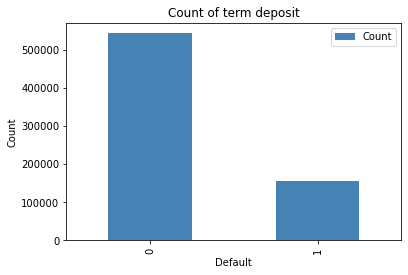

In [7]:
ax = y.value_counts().plot(kind='bar', title='Count of term deposit', color='steelblue')
ax.set_xlabel('Default')
ax.set_ylabel('Count')
ax.legend(['Count'])

plt.rcParams['figure.figsize'] = [10, 6]
plt.show()

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42,stratify=y)
smote = SMOTE()
X_resampled, Y_resampled = smote.fit_resample(x_train, y_train)
np.bincount(Y_resampled)

array([380751, 380751], dtype=int64)

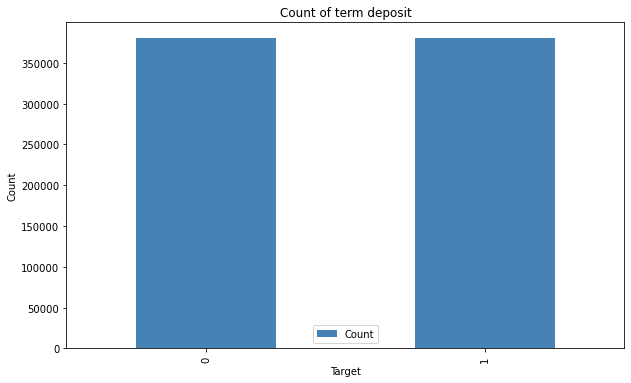

In [9]:
ax = Y_resampled.value_counts().plot(kind='bar', title='Count of term deposit', color='steelblue')

ax.set_xlabel('Target')
ax.set_ylabel('Count')
ax.legend(['Count'])
plt.rcParams['figure.figsize'] = [10, 6]
plt.show()

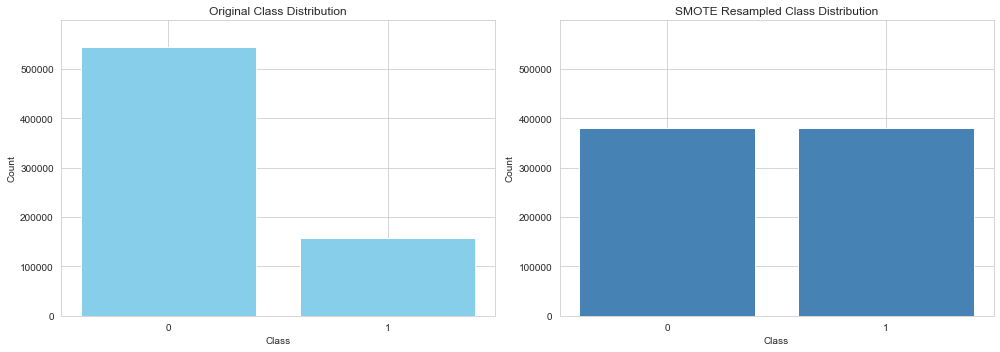

In [10]:
sns.set_style("whitegrid")

# Prepare value counts
original_counts = y.value_counts()
resampled_counts = Y_resampled.value_counts()

# Create side-by-side bar plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot original distribution
axes[0].bar(original_counts.index.astype(str), original_counts.values, color='skyblue')
axes[0].set_title('Original Class Distribution')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].set_ylim(0, max(original_counts.max(), resampled_counts.max()) * 1.1)

# Plot resampled distribution
axes[1].bar(resampled_counts.index.astype(str), resampled_counts.values, color='steelblue')
axes[1].set_title('SMOTE Resampled Class Distribution')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')
axes[1].set_ylim(0, max(original_counts.max(), resampled_counts.max()) * 1.1)

# Show the plot
plt.tight_layout()
plt.show()

In [11]:
def run_pca(X_resampled, Y_resampled, components=3, print_variance=True, scale_data=True):
    # Scale if requested
    if scale_data:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_resampled)
    else:
        X_scaled = X_resampled

    # Run PCA
    pca_model = PCA(n_components=components)
    principal_components = pca_model.fit_transform(X_scaled)

    # Print variance explained
    if print_variance:
        explained_variance = np.cumsum(pca_model.explained_variance_ratio_)
        print("Explained variance (cumulative):", explained_variance)

    # Create PC DataFrame
    pc_labels = [f'PC{i+1}' for i in range(components)]
    pc_df = pd.DataFrame(principal_components, columns=pc_labels)

    # Combine with target
    target_df = pd.Series(Y_resampled, name='Default')
    final_df = pd.concat([pc_df, target_df], axis=1)

    return final_df, pca_model

In [12]:
pca_df3, pca_model3 = run_pca(X_resampled, Y_resampled, components=3)

Explained variance (cumulative): [0.22203357 0.33432696 0.43117608]


In [13]:
pca_df2, pca_model2 = run_pca(X_resampled, Y_resampled, components=2)

Explained variance (cumulative): [0.22203357 0.33432695]


In [14]:
pca_df13, pca_model13 = run_pca(X_resampled, Y_resampled, components=13)

Explained variance (cumulative): [0.22203357 0.33432696 0.43117608 0.50822781 0.5831865  0.65666256
 0.72521853 0.78941657 0.84790814 0.89845311 0.94278196 0.97468803
 1.        ]


In [15]:
pca_df9, pca_model9 = run_pca(X_resampled, Y_resampled, components=9)

Explained variance (cumulative): [0.22203357 0.33432696 0.43117608 0.50822781 0.5831865  0.65666256
 0.72521853 0.78941657 0.84790814]


In [16]:
pca_model3.explained_variance_ratio_

array([0.22203357, 0.11229339, 0.09684912])

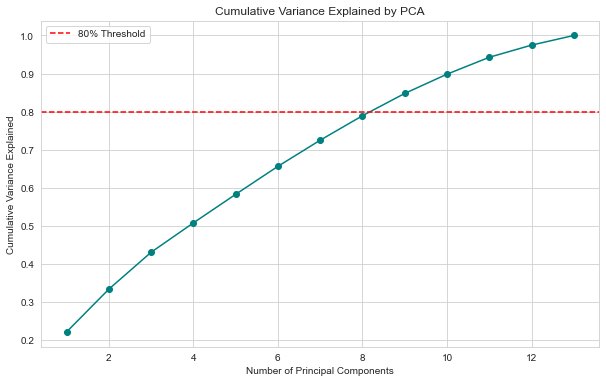

In [17]:
def plot_cumulative_variance(pca_model, save=False):

    cumulative_variance = np.cumsum(pca_model.explained_variance_ratio_)

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', color='teal')
    plt.axhline(y=0.8, color='red', linestyle='--', label='80% Threshold')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Variance Explained')
    plt.title('Cumulative Variance Explained by PCA')
    plt.grid(True)
    plt.legend()

    if save:
        plt.savefig("Cumulative_Variance_Explained.png", bbox_inches='tight', dpi=300)

    plt.show()

plot_cumulative_variance(pca_model13)

#### We need 9 PC's to explain over 80% of variance

In [18]:
def plot_pca_from_df(pc_df, save=True):

    from matplotlib.colors import ListedColormap

    # Use red and blue for high contrast
    contrast_cmap = ListedColormap(['#1f77b4', '#d62728'])

    pcs = [col for col in pc_df.columns if col.startswith('PC')]
    
    if len(pcs) < 2:
        raise ValueError("Need at least 2 principal components to plot.")

    elif len(pcs) == 2:
        plt.figure(figsize=(15, 7))
        scatter = plt.scatter(
            pc_df[pcs[0]], pc_df[pcs[1]],
            c=pc_df['Default'],
            cmap=contrast_cmap,
            alpha=0.7,
            edgecolors='k',
            linewidths=0.2
        )
        plt.title('Principal Component Analysis (2D)', fontsize=18, fontweight='bold')
        plt.xlabel(pcs[0])
        plt.ylabel(pcs[1])
        plt.colorbar(scatter, label='Default')
        if save:
            plt.savefig('PCA_2D_Projection.jpg', bbox_inches='tight', dpi=300)
        plt.show()

    elif len(pcs) >= 3:
        from mpl_toolkits.mplot3d import Axes3D
        fig = plt.figure(figsize=(15, 7))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(
            pc_df[pcs[0]], pc_df[pcs[1]], pc_df[pcs[2]],
            c=pc_df['Default'],
            cmap=contrast_cmap,
            alpha=0.7,
            edgecolors='k'
        )
        ax.set_title('Principal Component Analysis (3D)', fontsize=16, fontweight='bold')
        ax.set_xlabel(pcs[0])
        ax.set_ylabel(pcs[1])
        ax.set_zlabel(pcs[2])
        fig.colorbar(scatter, label='Default')
        if save:
            plt.savefig('PCA_3D_Projection.jpg', bbox_inches='tight', dpi=300)
        plt.show()


C:\Users\caoimhin\AppData\Local\Temp\ipykernel_10192\3344547654.py:46: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(scatter, label='Default')


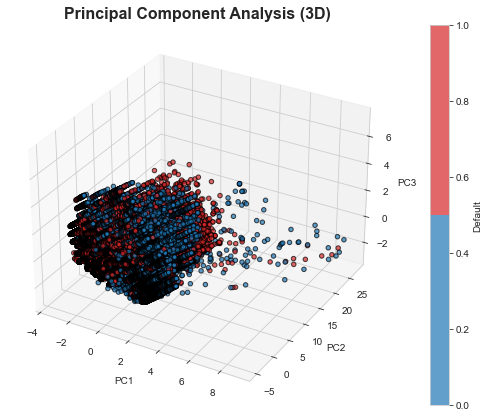

In [19]:
plot_pca_from_df(pca_df3)

C:\Users\caoimhin\AppData\Local\Temp\ipykernel_10192\3344547654.py:26: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(scatter, label='Default')


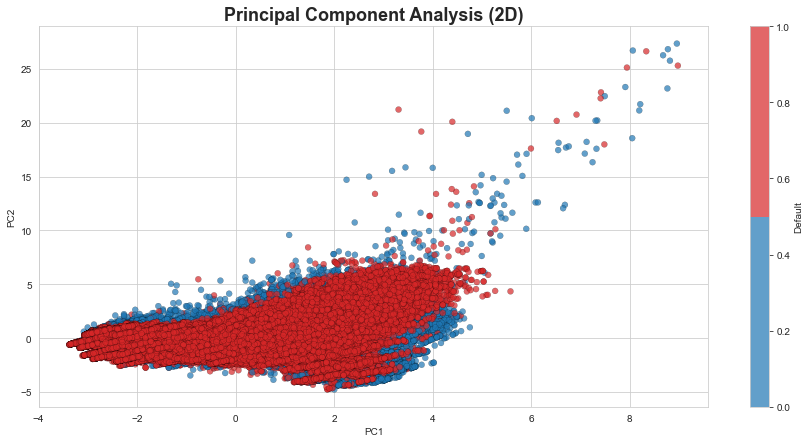

In [20]:
plot_pca_from_df(pca_df2)

C:\Users\caoimhin\AppData\Local\Temp\ipykernel_10192\3344547654.py:46: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(scatter, label='Default')


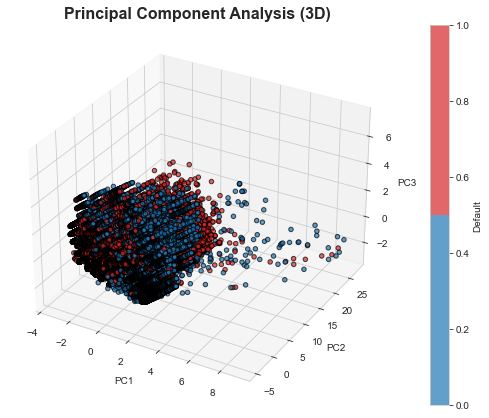

In [21]:
plot_pca_from_df(pca_df9)

In [22]:
def xgboost_feature_importance_resampled(X_resampled, Y_resampled, feature_names=None, test_size=0.2, random_state=42):
    # Handle feature naming
    if isinstance(X_resampled, pd.DataFrame):
        X = X_resampled.copy()
    else:
        if feature_names is None:
            feature_names = [f'Feature {i+1}' for i in range(X_resampled.shape[1])]
        X = pd.DataFrame(X_resampled, columns=feature_names)

    y = pd.Series(Y_resampled)

    # Scale
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=test_size, random_state=random_state)

    # Model
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=random_state
    )
    model.fit(X_train, y_train)

    # Gain-based
    importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=True)

    plt.figure(figsize=(10, 8))
    sns.barplot(x=importances, y=importances.index, color='crimson')
    plt.title("XGBoost Feature Importance (Gain)")
    plt.xlabel("Gain")
    plt.tight_layout()
    plt.show()

    # Permutation-based
    perm = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=random_state)
    perm_importance = pd.Series(perm.importances_mean, index=X.columns).sort_values(ascending=True)

    plt.figure(figsize=(10, 8))
    sns.barplot(x=perm_importance, y=perm_importance.index, color='darkblue')
    plt.title("Feature Importance (Permutation)")
    plt.xlabel("Mean Decrease in Performance")
    plt.tight_layout()
    plt.show()

    return importances, perm_importance

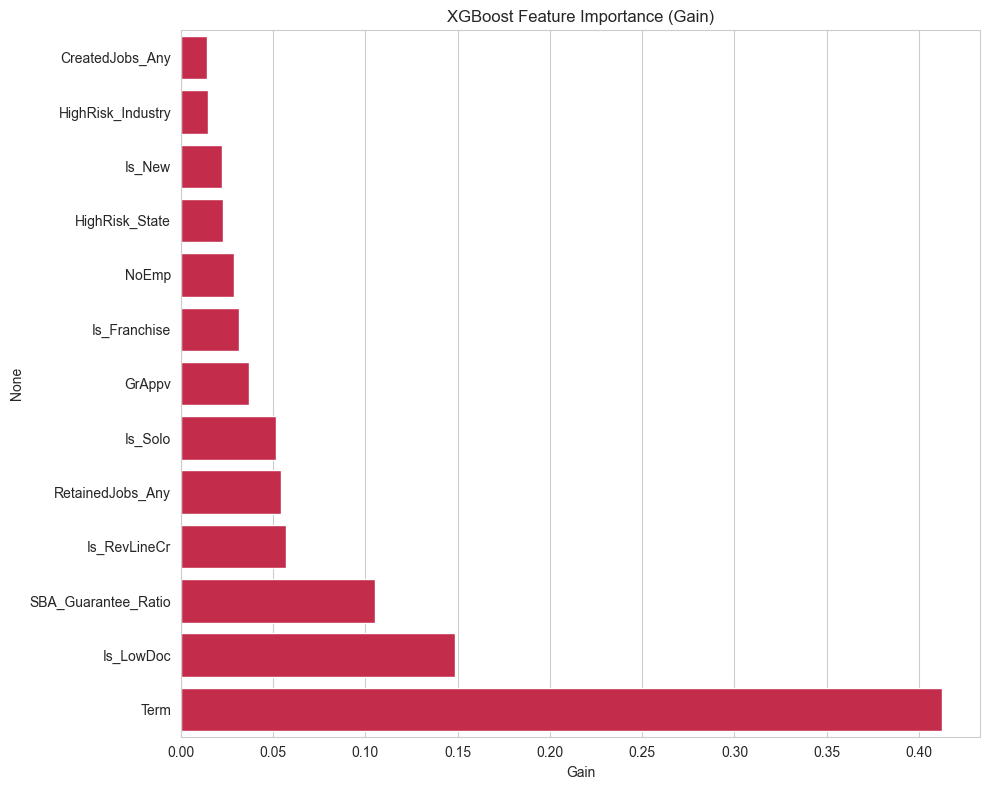

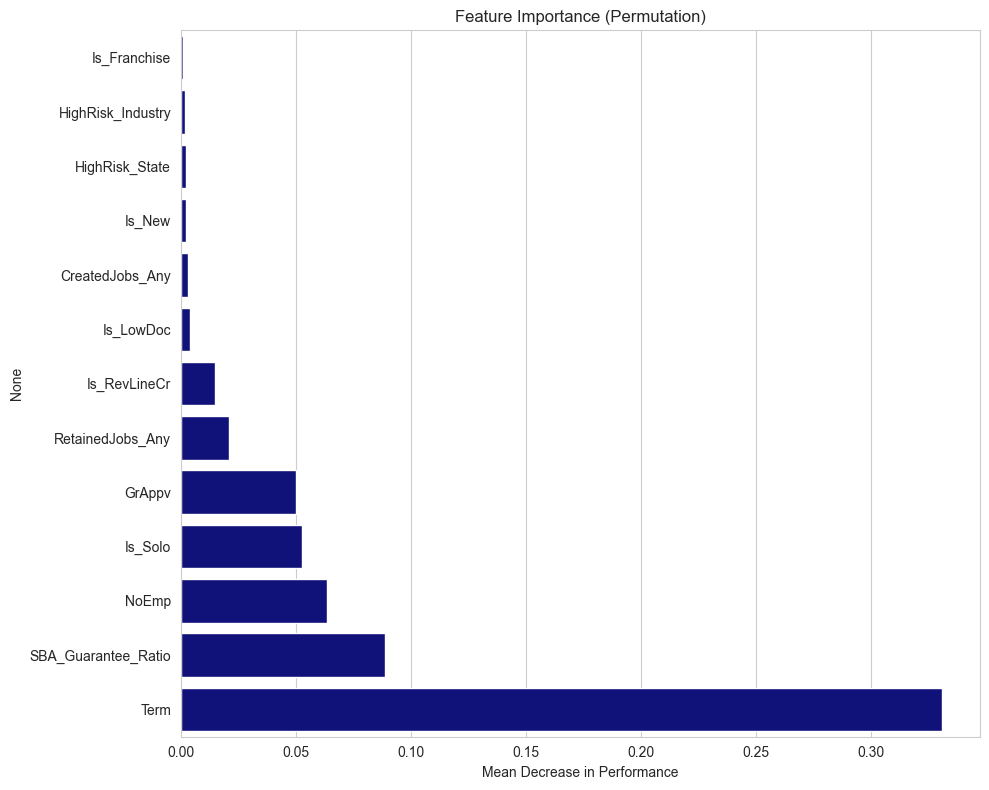

In [22]:
gain_imp, perm_imp = xgboost_feature_importance_resampled(X_resampled, Y_resampled)

In [23]:
def highlight_top_features(feature_series, threshold=0.05, title="Most Influential Features", save=False):
    # Plot all importances
    plt.figure(figsize=(12, 6))
    plt.plot(feature_series.values, marker='o', linestyle='-')
    plt.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold: {threshold}')
    plt.title(title, fontsize=16, fontweight='bold')
    plt.ylabel("Importance")
    plt.xlabel("Feature Index")
    plt.grid(True)
    plt.legend()

    if save:
        plt.savefig(f"{title.replace(' ', '_')}.png", bbox_inches='tight', dpi=300)

    plt.show()

    # Filter and sort features above threshold
    above_thresh = feature_series[feature_series > threshold].sort_values(ascending=False)

    # Build and print table
    table_data = [(i + 1, name, f"{val:.4f}") for i, (name, val) in enumerate(above_thresh.items())]
    headers = ["Index", "Feature Name", "Importance"]

    print(f"\nFeatures with values greater than {threshold} (sorted by importance):")
    print("=" * 60)
    print(tabulate(table_data, headers=headers, tablefmt="pipe", stralign='left', numalign='right'))
    print("=" * 60)

    return above_thresh

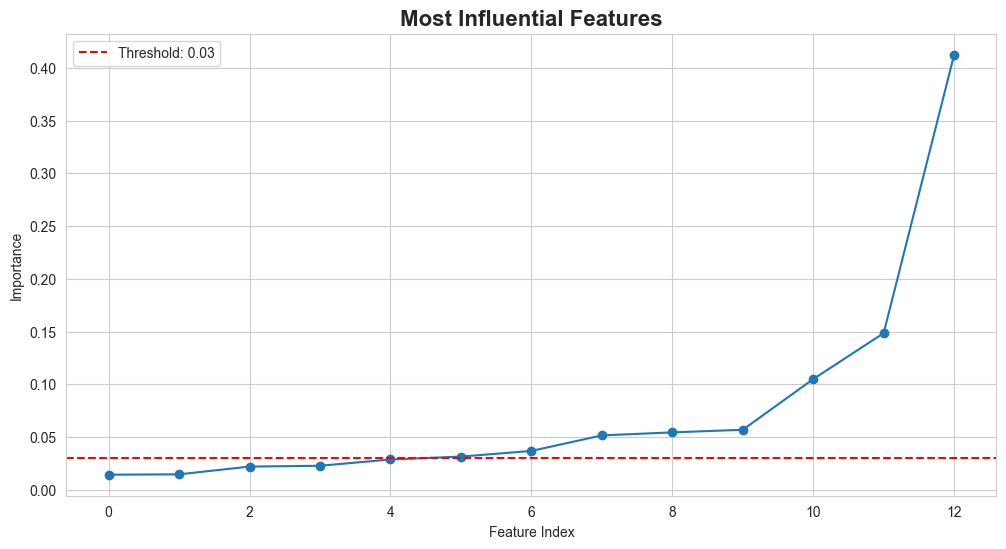


Features with values greater than 0.03 (sorted by importance):
|   Index | Feature Name        |   Importance |
|--------:|:--------------------|-------------:|
|       1 | Term                |       0.4124 |
|       2 | Is_LowDoc           |       0.1485 |
|       3 | SBA_Guarantee_Ratio |        0.105 |
|       4 | Is_RevLineCr        |       0.0569 |
|       5 | RetainedJobs_Any    |       0.0545 |
|       6 | Is_Solo             |       0.0516 |
|       7 | GrAppv              |       0.0369 |
|       8 | Is_Franchise        |       0.0315 |


In [24]:
top_features = highlight_top_features(gain_imp, threshold=0.03)

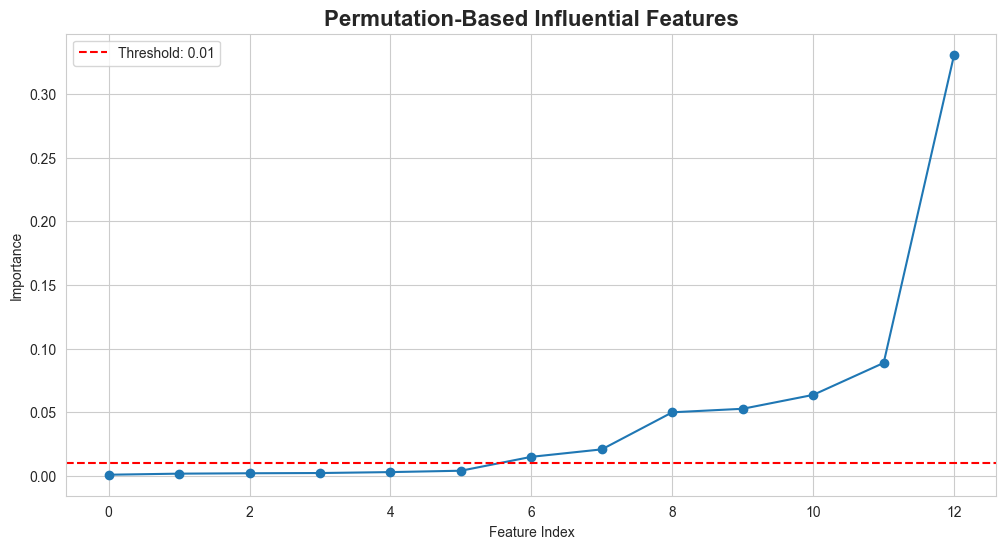


Features with values greater than 0.01 (sorted by importance):
|   Index | Feature Name        |   Importance |
|--------:|:--------------------|-------------:|
|       1 | Term                |       0.3307 |
|       2 | SBA_Guarantee_Ratio |       0.0887 |
|       3 | NoEmp               |       0.0636 |
|       4 | Is_Solo             |       0.0527 |
|       5 | GrAppv              |       0.0499 |
|       6 | RetainedJobs_Any    |       0.0208 |
|       7 | Is_RevLineCr        |        0.015 |


In [25]:
top_perm = highlight_top_features(perm_imp, threshold=0.01, title="Permutation-Based Influential Features")

In [26]:
def plot_most_influential_features(feature_series, threshold=0.05, save=True):
    # Get values and feature names
    original_features = feature_series.values
    feature_names = feature_series.index

    # Identify features above the threshold
    above_thresh_indices = np.where(original_features > threshold)[0]
    selected_names = feature_names[above_thresh_indices]
    selected_values = original_features[above_thresh_indices]

    # Sort selected features by value (descending)
    sorted_columns = sorted(zip(selected_names, selected_values), key=lambda x: x[1], reverse=True)

    # --- PLOTTING ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

    # Line plot of all feature importances
    ax1.plot(original_features, marker='o', linestyle='-')
    ax1.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold: {threshold}')
    ax1.set_title('Most Influential Features', fontweight='bold', fontsize=16)
    ax1.set_xlabel('Feature Index')
    ax1.set_ylabel('Importance')
    ax1.grid(True)
    ax1.legend()

    # Horizontal bar chart of top features
    if sorted_columns:
        top_names, top_values = zip(*sorted_columns)
        indices = np.arange(len(top_names))
        ax2.barh(indices, top_values, color='steelblue')
        ax2.set_yticks(indices)
        ax2.set_yticklabels(top_names)
        ax2.invert_yaxis()
        ax2.set_xlabel('Importance')
        ax2.set_title(f'Most Influential Features (Threshold > {threshold})', fontweight='bold', fontsize=16)

    else:
        ax2.set_title("No Features Exceed Threshold", fontweight='bold')

    fig.subplots_adjust(wspace=0.4)

    # Save figure
    if save:
        plt.savefig("Most_Influential_Features_Combined.jpg", bbox_inches='tight', dpi=300)

    plt.show()

    # Table output
    table_data = [(i + 1, name, f"{val:.4f}") for i, (name, val) in enumerate(sorted_columns)]
    headers = ["Index", "Feature Name", "Importance"]

    print(f"\nFeatures with values greater than {threshold} (sorted by importance):")
    print("=" * 60)
    print(tabulate(table_data, headers=headers, tablefmt="pipe", stralign='left', numalign='right'))
    print("=" * 60)

    # Return as Series
    return feature_series.loc[[name for name, _ in sorted_columns]]

# Feature Importance Most Important Features

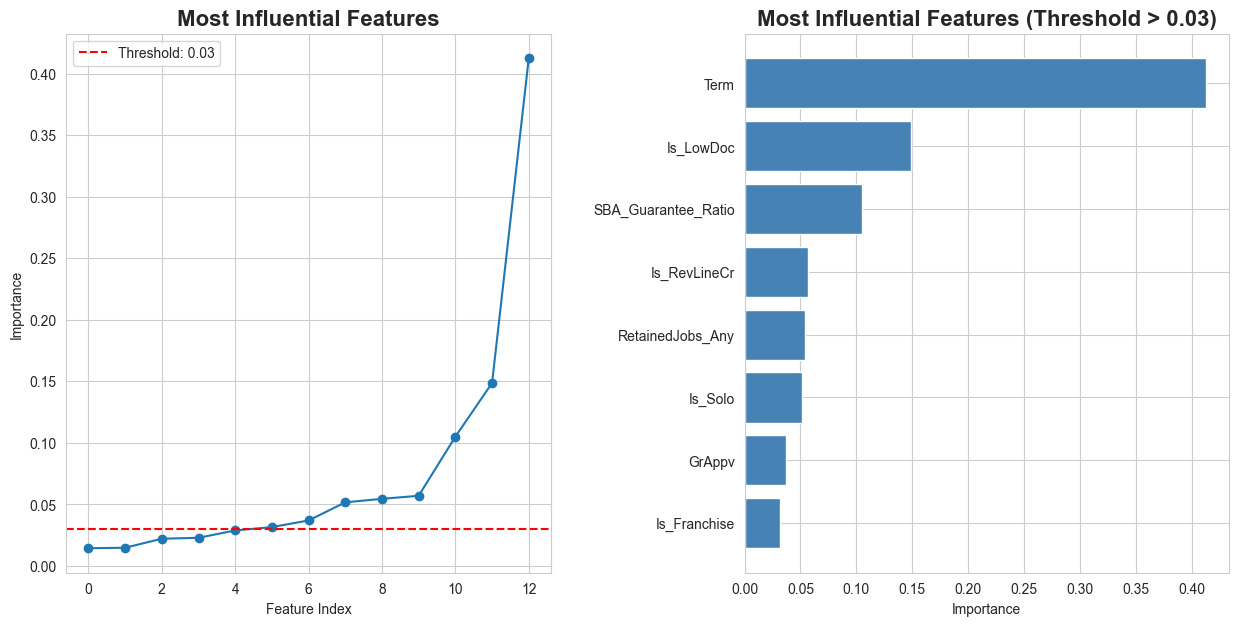


Features with values greater than 0.03 (sorted by importance):
|   Index | Feature Name        |   Importance |
|--------:|:--------------------|-------------:|
|       1 | Term                |       0.4124 |
|       2 | Is_LowDoc           |       0.1485 |
|       3 | SBA_Guarantee_Ratio |        0.105 |
|       4 | Is_RevLineCr        |       0.0569 |
|       5 | RetainedJobs_Any    |       0.0545 |
|       6 | Is_Solo             |       0.0516 |
|       7 | GrAppv              |       0.0369 |
|       8 | Is_Franchise        |       0.0315 |


In [27]:
top_features = plot_most_influential_features(gain_imp, threshold=0.03)

# Pemutation Feature Importance Most Important Features

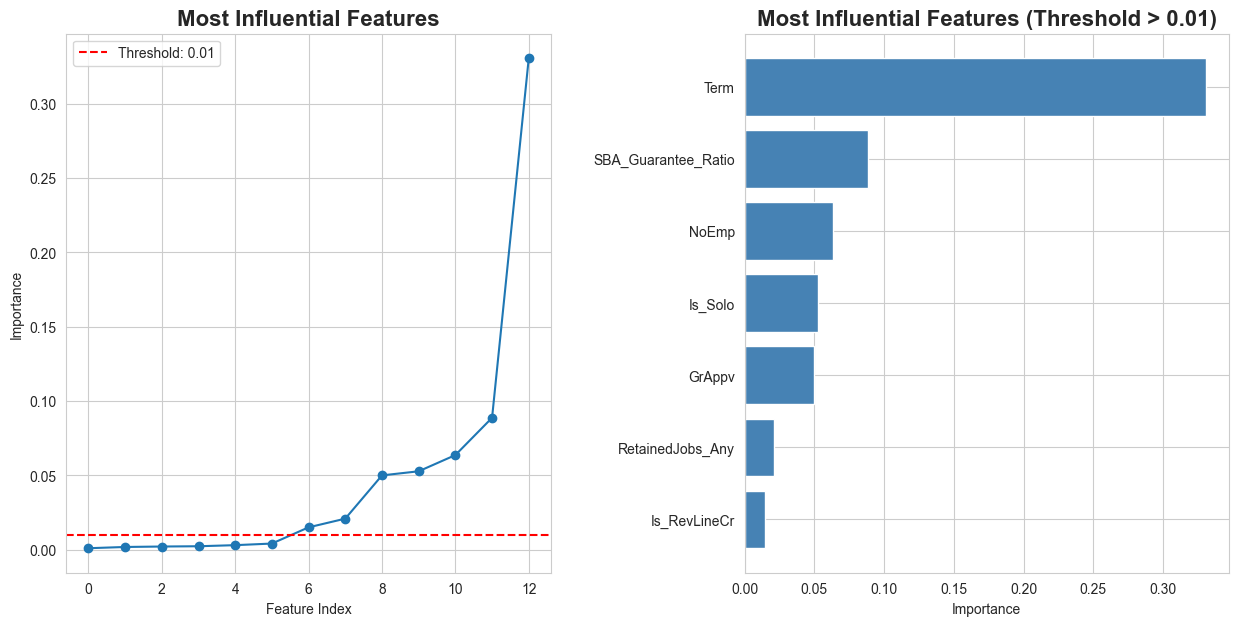


Features with values greater than 0.01 (sorted by importance):
|   Index | Feature Name        |   Importance |
|--------:|:--------------------|-------------:|
|       1 | Term                |       0.3307 |
|       2 | SBA_Guarantee_Ratio |       0.0887 |
|       3 | NoEmp               |       0.0636 |
|       4 | Is_Solo             |       0.0527 |
|       5 | GrAppv              |       0.0499 |
|       6 | RetainedJobs_Any    |       0.0208 |
|       7 | Is_RevLineCr        |        0.015 |


In [28]:
top_perm = plot_most_influential_features(perm_imp, threshold=0.01)

In [29]:
proportion_variance = pca_model13.explained_variance_ratio_

# Scree Plot

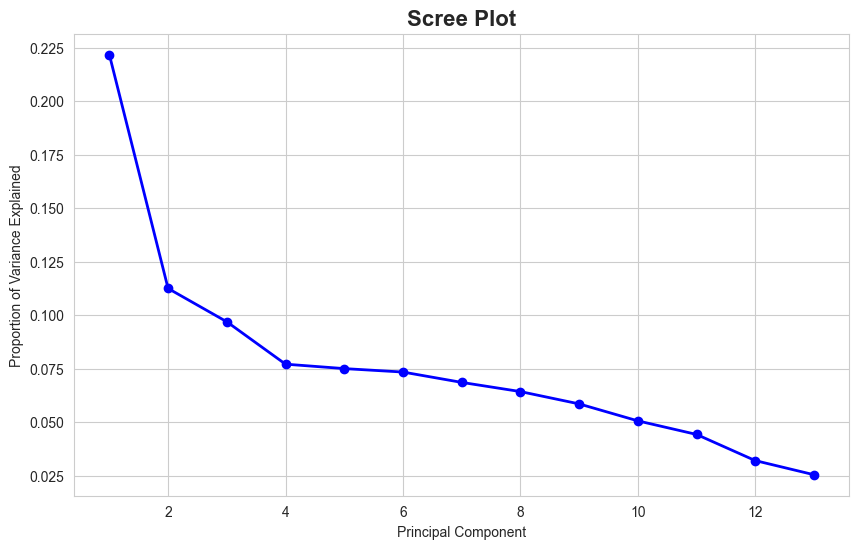

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(proportion_variance)+1), proportion_variance, 'bo-', linewidth=2)
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.title('Scree Plot', fontweight='bold', fontsize=16)
plt.grid(True)
plt.show()

<h4> We will go with 9 Principal Components as it explains 71 of variance <h4>

In [31]:
principal_df = pca_df3

# Elbow Plot For Optimal Number of Clusters

In [32]:
!pip install yellowbrick

Defaulting to user installation because normal site-packages is not writeable


#### Incorporated clustering using PCA dta as oppposed to Original dataset as Kmeans & Hierchial Clustering wroks best when the data is compact and well-distributed

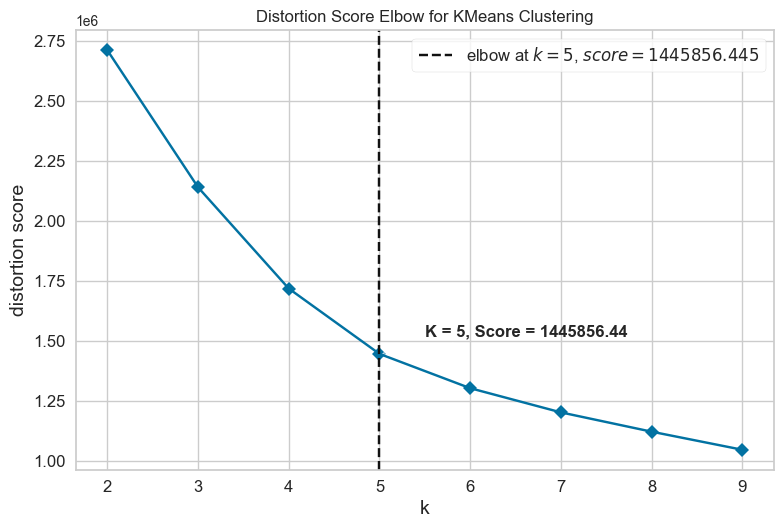

Optimal K determined by Elbow Method: 5


In [33]:
from yellowbrick.cluster import KElbowVisualizer
X_scaled = StandardScaler().fit_transform(X_resampled)

# Step 2: Create and fit the Elbow Visualizer
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2, 10), timings=False)
visualizer.fit(principal_df)

# Step 3: Get elbow point and score
elbow_k = visualizer.elbow_value_
k_values = visualizer.k_values_          # List of k tried
scores = visualizer.k_scores_           # Distortion scores
elbow_score = scores[k_values.index(elbow_k)]

# Step 4: Customize the plot and annotate
plt.gca().set_title('Optimal K value with Elbow Method', fontsize=18, fontweight='bold')
plt.gca().set_xlabel('Number of Clusters (K)', fontsize=14)
plt.gca().set_ylabel('Distortion Score', fontsize=14)
plt.grid(True)
plt.gca().tick_params(axis='both', which='major', labelsize=12)

plt.gca().annotate(
    f"K = {elbow_k}, Score = {elbow_score:.2f}",
    xy=(elbow_k, elbow_score),
    xytext=(elbow_k + 0.5, elbow_score + 0.05 * elbow_score),
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    fontsize=12,
    fontweight='bold'
)

# Step 5: Show the final plot
plt.tight_layout()
visualizer.show()

# Optional print
print(f"Optimal K determined by Elbow Method: {elbow_k}")

#### We have choosen 5 as our optimal number of clusters when using 3 PCs

/Users/roryobrien/Library/Python/3.12/lib/python/site-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/Users/roryobrien/Library/Python/3.12/lib/python/site-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


ValueError: None is not in list

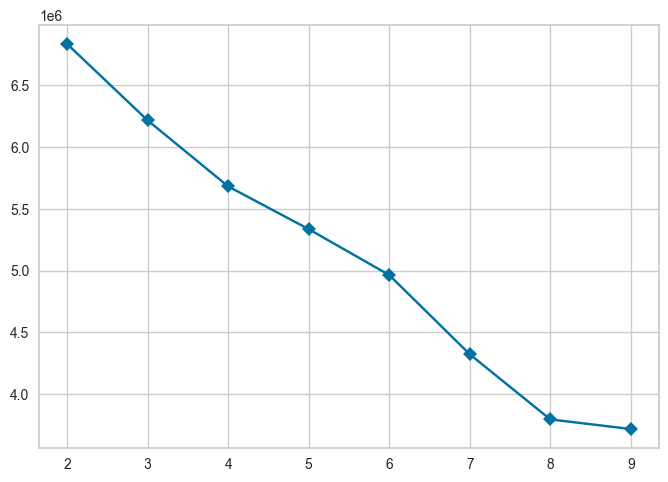

In [34]:
from yellowbrick.cluster import KElbowVisualizer
X_scaled = StandardScaler().fit_transform(X_resampled)

# Step 2: Create and fit the Elbow Visualizer
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2, 10), timings=False)
visualizer.fit(pca_df9)

# Step 3: Get elbow point and score
elbow_k = visualizer.elbow_value_
k_values = visualizer.k_values_          # List of k tried
scores = visualizer.k_scores_           # Distortion scores
elbow_score = scores[k_values.index(elbow_k)]

# Step 4: Customize the plot and annotate
plt.gca().set_title('Optimal K value with Elbow Method', fontsize=18, fontweight='bold')
plt.gca().set_xlabel('Number of Clusters (K)', fontsize=14)
plt.gca().set_ylabel('Distortion Score', fontsize=14)
plt.grid(True)
plt.gca().tick_params(axis='both', which='major', labelsize=12)

plt.gca().annotate(
    f"K = {elbow_k}, Score = {elbow_score:.2f}",
    xy=(elbow_k, elbow_score),
    xytext=(elbow_k + 0.5, elbow_score + 0.05 * elbow_score),
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    fontsize=12,
    fontweight='bold'
)

# Step 5: Show the final plot
plt.tight_layout()
visualizer.show()

# Optional print
print(f"Optimal K determined by Elbow Method: {elbow_k}")

In [30]:
pca_df9

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,Default
0,-2.210664,0.739805,0.468515,0.378380,0.861384,-0.674008,0.392894,-0.256744,-0.524016,0
1,-1.997040,0.254297,-1.049652,1.011570,0.405248,-0.490575,-0.372071,0.542932,-0.548676,0
2,-1.093864,0.628954,-0.047451,0.435660,-1.200778,0.087849,0.792015,1.005496,0.071326,0
3,-2.171122,0.496819,-0.552512,0.540145,-1.547661,0.012808,0.016904,0.674862,-0.596938,1
4,-1.829937,0.733574,-1.133255,0.066923,-1.631328,0.491989,-0.608675,-0.897371,-0.245779,1
...,...,...,...,...,...,...,...,...,...,...
761497,1.025857,-1.446970,0.108712,0.388993,0.641717,-0.475203,0.381061,0.449827,-1.075966,1
761498,-2.294692,-1.497628,0.820282,-0.372448,-1.029701,1.480679,-1.356115,1.080248,-1.198794,1
761499,2.373012,1.879591,-0.388166,-0.449221,0.573863,-0.284711,-0.734385,0.190685,-0.178167,1
761500,-1.137877,-1.009182,1.281750,-0.868995,1.600612,0.390776,0.931542,0.561188,1.782145,1


In [31]:
# Extract all 3 principal components for clustering
X_pca_only = pca_df3[[f'PC{i}' for i in range(1, 4)]]

# Fit KMeans on the full PCA-reduced data
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=200)
kmeans_labels = kmeans.fit_predict(X_pca_only)

# Add cluster labels to the DataFrame
pca_df3['cluster_label'] = kmeans_labels

# One-hot encode the cluster labels
pca_cluster_df = pd.get_dummies(pca_df3, columns=['cluster_label'], prefix='cluster')

In [32]:
pca_cluster_df

,PC1,PC2,PC3,Default,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4
0,-2.210664,0.739805,0.468515,0,0,0,0,1,0
1,-1.997040,0.254297,-1.049652,0,0,0,0,1,0
2,-1.093864,0.628954,-0.047451,0,0,0,0,1,0
3,-2.171122,0.496819,-0.552512,1,0,0,0,1,0
4,-1.829937,0.733574,-1.133255,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...
761497,1.025857,-1.446970,0.108712,1,0,0,0,0,1
761498,-2.294692,-1.497628,0.820282,1,0,0,0,1,0
761499,2.373012,1.879591,-0.388166,1,0,1,0,0,0
761500,-1.137877,-1.009182,1.281750,1,1,0,0,0,0


C:\Users\caoimhin\AppData\Local\Temp\ipykernel_10192\3122617180.py:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(scatter, label='Cluster')


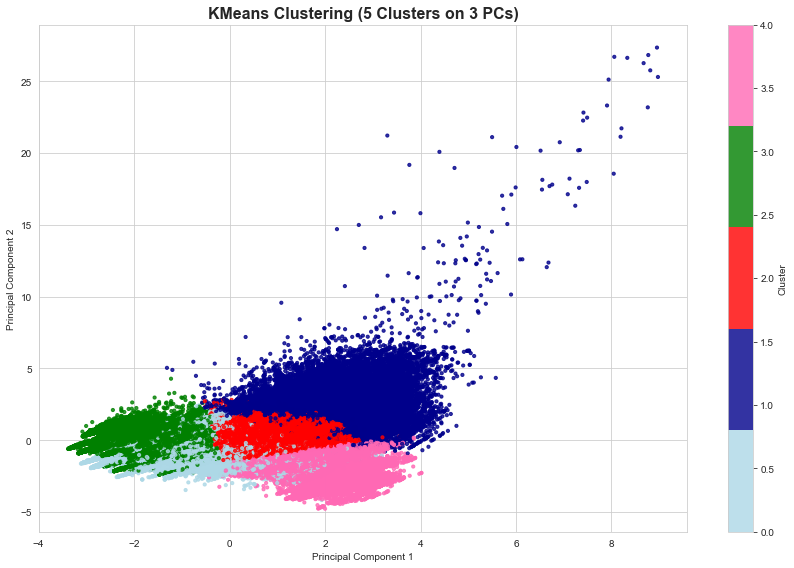

In [33]:
# 2D plot using PC1 and PC2
from matplotlib.colors import ListedColormap
cluster_colors = ListedColormap(['#ADD8E6','#00008B','#FF0000','#008000', '#FF69B4'])
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    pca_df3['PC1'], pca_df3['PC2'],
    c=pca_df3['cluster_label'], cmap=cluster_colors, s=10, alpha=0.8
)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KMeans Clustering (5 Clusters on 3 PCs)', fontsize=16, fontweight='bold')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

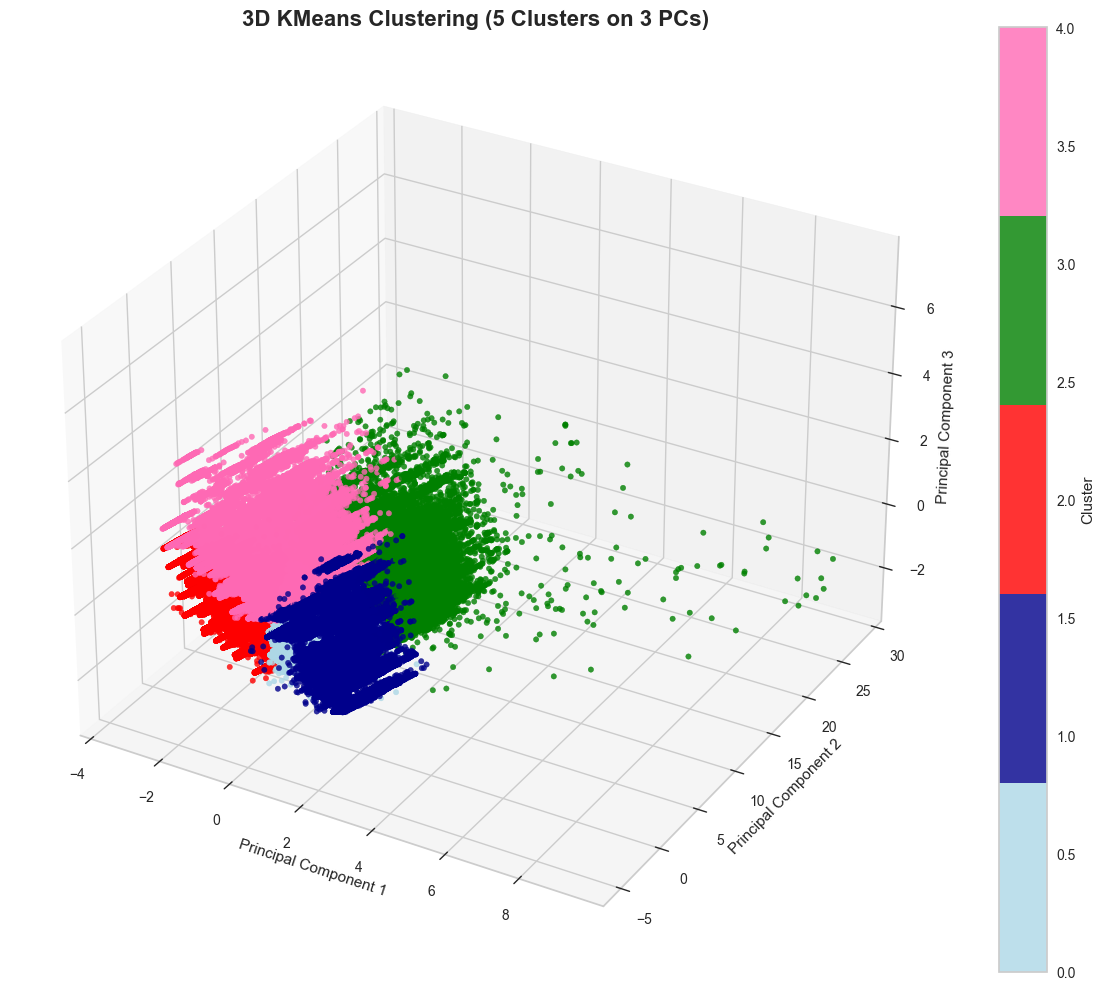

In [39]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    pca_df3['PC1'], pca_df3['PC2'], pca_df3['PC3'],
    c=pca_df3['cluster_label'], cmap=cluster_colors, s=15, alpha=0.8
)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D KMeans Clustering (5 Clusters on 3 PCs)', fontsize=16, fontweight='bold')
plt.colorbar(sc, label='Cluster')
plt.tight_layout()
plt.show()

In [24]:
pca_data = pca_df9

#### Save the one-hot encoded version as csv for purpose of Logistic regression

In [41]:
pca_data.to_csv('pca_data.csv')

In [42]:
pca_cluster_df.to_csv('pca_cluster_data.csv')

#### Collapse Clusters into single column for ML implementation

In [43]:
# Reconstruct original cluster label from one-hot encoded columns
pca_cluster_df['cluster_label'] = pca_cluster_df[
    ['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4']
].idxmax(axis=1).str.extract('(\d)').astype(int) 

# Drop one-hot encoded cluster columns (optional)
pca_cluster_df.drop(columns=['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4'], inplace=True)

pca_cluster_df

<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:4: SyntaxWarning: invalid escape sequence '\d'
/var/folders/sy/bxcftcdx75n3w7kv3ljkq2p40000gn/T/ipykernel_31042/901038445.py:4: SyntaxWarning: invalid escape sequence '\d'
  ].idxmax(axis=1).str.extract('(\d)').astype(int)


,PC1,PC2,PC3,Default,cluster_label
0,-2.212630,0.739698,0.471877,0,2
1,-1.997808,0.260432,-1.044656,0,2
2,-1.091734,0.633304,-0.049870,0,2
3,-2.171384,0.501243,-0.555358,1,2
4,-1.831272,0.736598,-1.140062,1,2
...,...,...,...,...,...
761497,-2.096222,0.058786,-1.091745,1,2
761498,1.189576,0.401931,-1.193095,1,0
761499,-2.251292,0.998584,0.197738,1,2
761500,-0.294733,-1.128929,0.361743,1,4


In [44]:
import ML_pipeline as ml

## Supervised machine learning using PC's

In [45]:
pca_data

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,Default
0,-2.212630,0.739698,0.471877,0.376789,0.873683,-0.657240,0.392078,-0.262658,-0.535535,0
1,-1.997808,0.260432,-1.044656,1.021606,0.432102,-0.473718,-0.364218,0.553780,-0.547772,0
2,-1.091734,0.633304,-0.049870,0.445465,-1.203342,0.059681,0.794638,0.999269,0.071901,0
3,-2.171384,0.501243,-0.555358,0.555726,-1.542175,-0.021661,0.014429,0.678782,-0.597317,1
4,-1.831272,0.736598,-1.140062,0.089103,-1.633314,0.460529,-0.626720,-0.886787,-0.241792,1
...,...,...,...,...,...,...,...,...,...,...
761497,-2.096222,0.058786,-1.091745,0.672871,0.289068,-0.820494,-0.360304,0.502550,-0.521387,1
761498,1.189576,0.401931,-1.193095,-0.190201,0.438609,-0.328021,-0.211218,-0.478139,0.499528,1
761499,-2.251292,0.998584,0.197738,-0.211980,-1.105712,0.514858,0.264339,-1.840104,-0.067400,1
761500,-0.294733,-1.128929,0.361743,0.447034,0.792617,-0.555874,0.356102,0.324763,-1.132014,1


In [46]:
tuning_subsample = pca_data

In [47]:
X_train, X_test, X_train_scaled, X_test_scaled, y_train, y_test, feature_names = ml.preprocess_data(pca_data)

 Applied SMOTE: Resampled class distribution: {1: 266526, 0: 266526}


In [48]:
X_train_tune, X_test_tune, X_train_scaled_tune, X_test_scaled_tune, y_train_tune, y_test_tune, feature_names = ml.preprocess_data(tuning_subsample)  # this does not include smote sampling - the tuning set is not balanced

 Applied SMOTE: Resampled class distribution: {1: 266526, 0: 266526}


<h1> Random Forest with RandomSearchCV Tuning and Balanced Data</h1> 

In [50]:
model_type = 'rf'  # or 'xgb'
bal_model = ml.train_model(model_type, X_train_scaled, y_train, X_tune= X_train_scaled_tune, y_tune = y_train_tune, tune=True, n_iter = 10)  # tune=True enables RandomizedSearchCV for RF

Tuning combinations received, moving to model fitting ...

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 3.7min
[CV] END max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time= 3.7min
[CV] END max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time= 3.7min
[CV] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 3.7min
[CV] END max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time= 3.7min
[CV] END max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time= 3.7min
[CV] END max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time= 3.7min
[CV] END max_depth=10, max_features


 Test Set Evaluation:
Accuracy:  0.8736
Precision: 0.8723
Recall:    0.8753
F1 Score:  0.8738


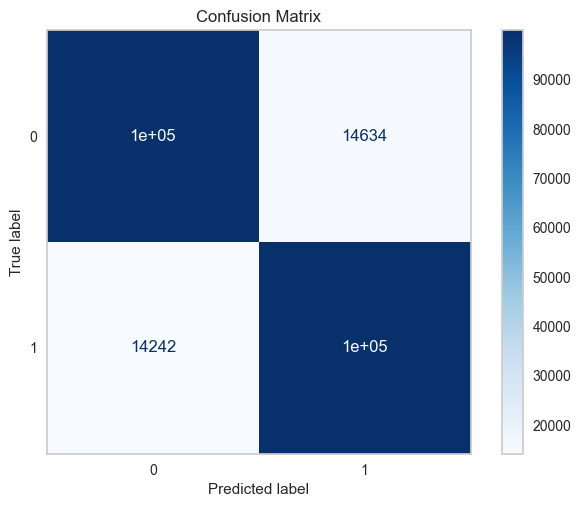

In [51]:
test_metrics = ml.evaluate_model(bal_model, X_test_scaled, y_test)

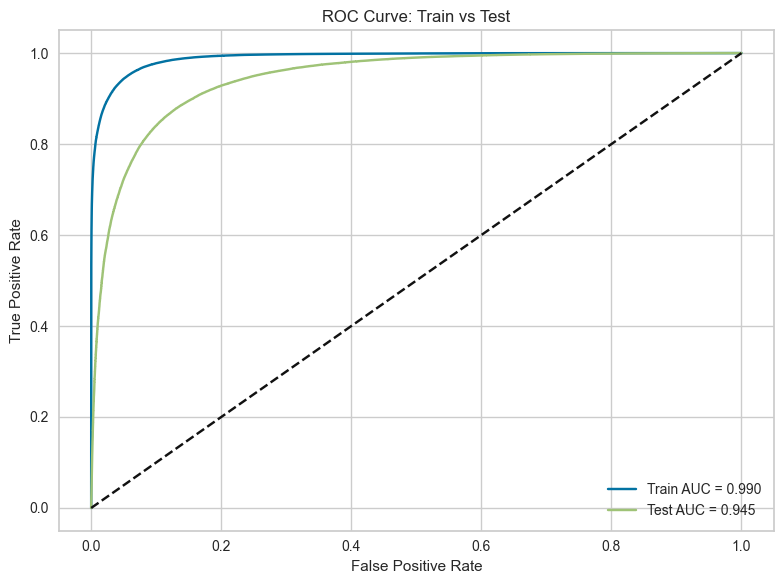

In [52]:
ml.plot_roc_train_vs_test(bal_model, X_train_scaled, y_train, X_test_scaled, y_test)


 Metrics across thresholds:
   Threshold     TPR     FPR  Precision  Error Rate  G Score  F1 Score     FNR
0       0.10  0.9886  0.4787     0.6737      0.2451   0.7179    0.8014  0.0114
1       0.20  0.9717  0.3387     0.7415      0.1835   0.8016    0.8412  0.0283
2       0.35  0.9329  0.2101     0.8162      0.1386   0.8584    0.8706  0.0671
3       0.50  0.8753  0.1281     0.8723      0.1264   0.8736    0.8738  0.1247


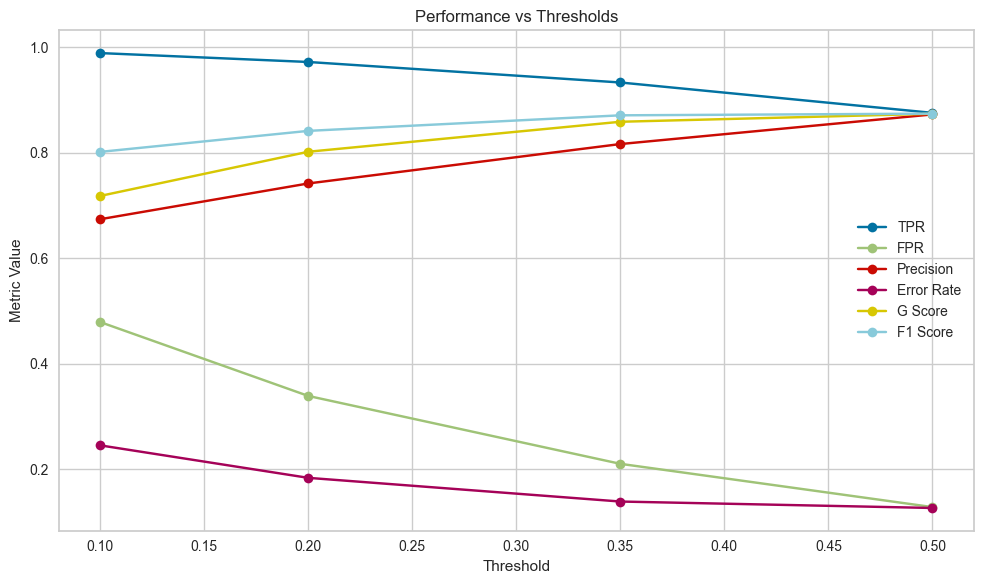

In [53]:
threshold_df = ml.evaluate_thresholds(bal_model, X_test_scaled, y_test, thresholds=[0.1, 0.2, 0.35, 0.5])
ml.plot_metrics_vs_thresholds(threshold_df)

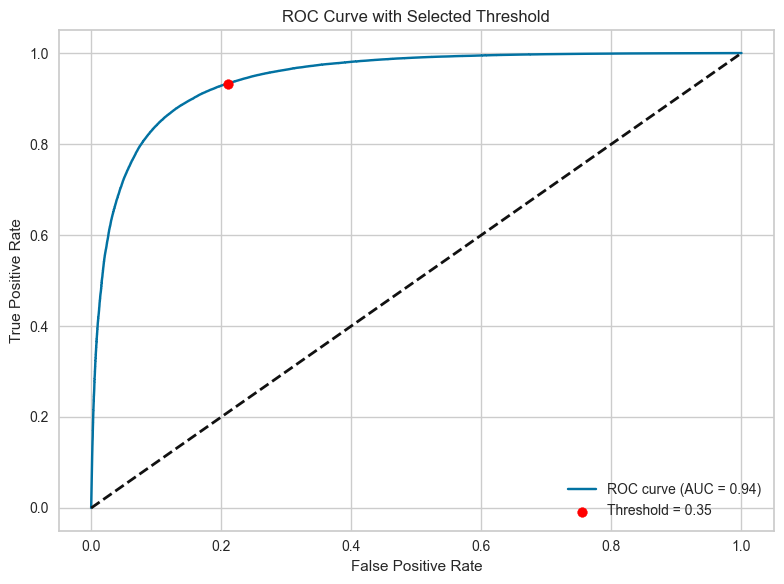

In [54]:
ml.plot_roc_with_threshold(bal_model, X_test_scaled, y_test, threshold=0.35)

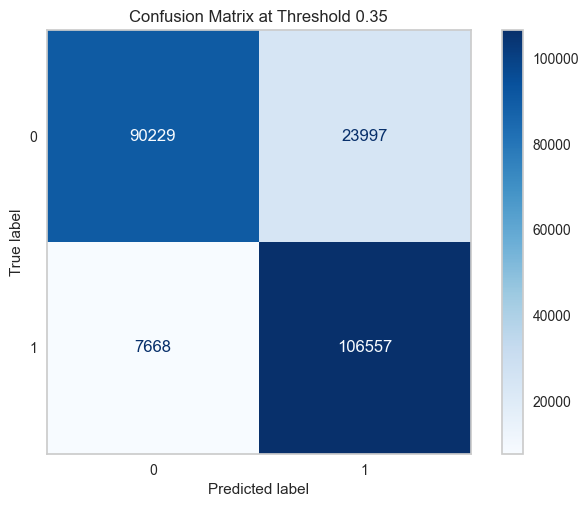

In [55]:
ml.plot_confusion_matrix_at_threshold(bal_model, X_test_scaled, y_test, threshold=0.35)

In [56]:
ml.cross_validate_thresholds(bal_model, X_train_scaled, y_train)


Cross-Validated F1 across thresholds:
   Threshold  f1_mean  f1_std
0       0.10   0.7961  0.0006
1       0.20   0.8355  0.0003
2       0.35   0.8656  0.0007
3       0.50   0.8683  0.0010


,Threshold,f1_mean,f1_std
0,0.10,0.7961,0.0006
1,0.20,0.8355,0.0003
2,0.35,0.8656,0.0007
3,0.50,0.8683,0.0010


<h1> XGBoost with RandomSearchCV Tuning </h1>

In [57]:
model_type = 'xgb'  
bal_model = ml.train_model(model_type, X_train_scaled, y_train,X_tune= X_train_scaled_tune, y_tune = y_train_tune, tune=True, n_iter= 20, scoring = "recall")  # tune=True enables tuning with option to choose RandomSearch or GridSearch

Tuning combinations received, moving to model fitting ...

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=1; total time=  10.5s
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=1; total time=  10.5s
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=1; total time=  10.5s
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=1; total time=  10.6s
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=1; total time=  10.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.8; total time=  16.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.8; total time=  16.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=


 Test Set Evaluation:
Accuracy:  0.8298
Precision: 0.8251
Recall:    0.8370
F1 Score:  0.8310


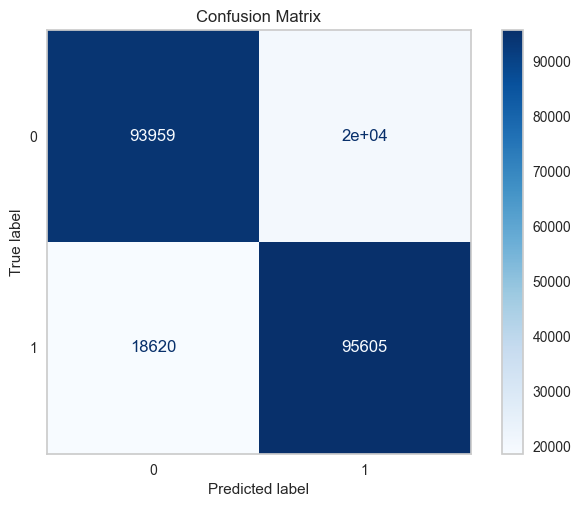

In [58]:
test_metrics = ml.evaluate_model(bal_model, X_test_scaled, y_test)

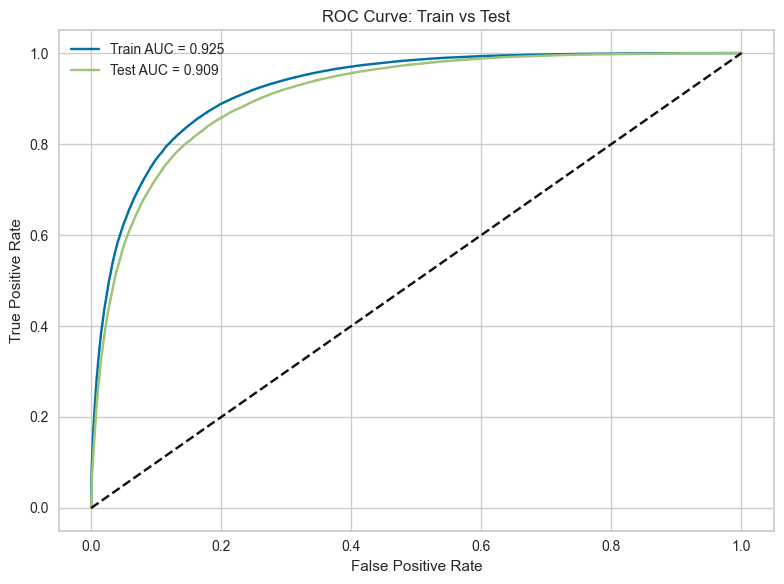

In [59]:
ml.plot_roc_train_vs_test(bal_model, X_train_scaled, y_train, X_test_scaled, y_test)


 Metrics across thresholds:
   Threshold     TPR     FPR  Precision  Error Rate  G Score  F1 Score     FNR
0       0.10  0.9893  0.6150     0.6167      0.3129   0.6172    0.7597  0.0107
1       0.20  0.9694  0.4613     0.6776      0.2460   0.7226    0.7976  0.0306
2       0.35  0.9161  0.2889     0.7603      0.1864   0.8072    0.8310  0.0839
3       0.50  0.8370  0.1774     0.8251      0.1702   0.8297    0.8310  0.1630


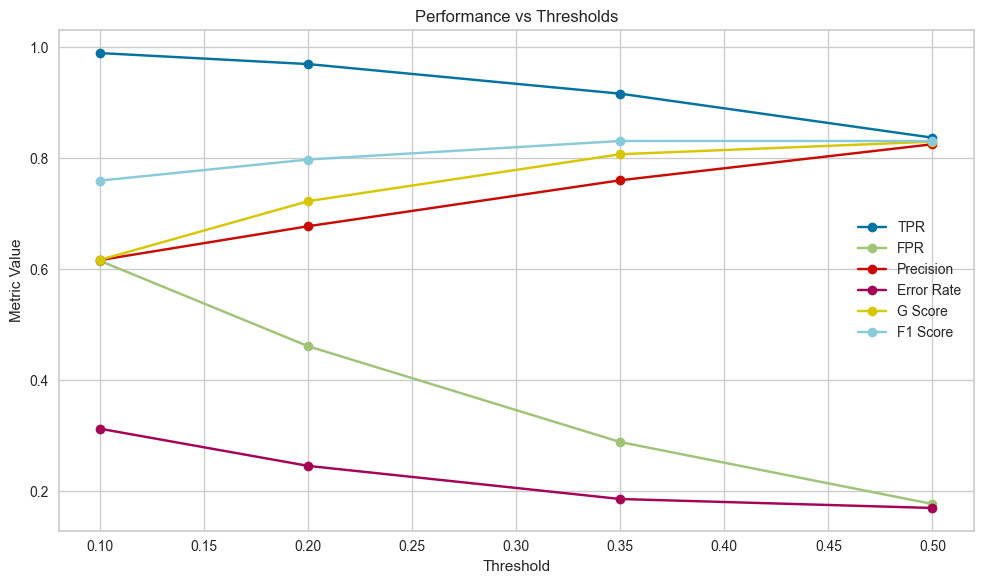

In [60]:
threshold_df = ml.evaluate_thresholds(bal_model, X_test_scaled, y_test, thresholds=[0.1, 0.2, 0.35, 0.5])
ml.plot_metrics_vs_thresholds(threshold_df)

## KNN

In [61]:
model_type = 'knn'
bal_model = ml.train_model(model_type, X_train_scaled, y_train, X_tune= X_train_scaled_tune, y_tune = y_train_tune, tune=True, n_iter = 10, scoring= "roc_auc")

Tuning combinations received, moving to model fitting ...

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END .....................................n_neighbors=10; total time=   8.4s
[CV] END .....................................n_neighbors=10; total time=   8.4s
[CV] END .....................................n_neighbors=11; total time=   8.5s
[CV] END .....................................n_neighbors=11; total time=   8.5s
[CV] END .....................................n_neighbors=11; total time=   8.6s
[CV] END .....................................n_neighbors=11; total time=   8.7s
[CV] END .....................................n_neighbors=11; total time=   8.8s
[CV] END .....................................n_neighbors=10; total time=   8.9s
[CV] END ......................................n_neighbors=1; total time=   3.1s
[CV] END ......................................n_neighbors=1; total time=   3.4s
[CV] END ......................................n_neighbors=1; total ti


 Test Set Evaluation:
Accuracy:  0.8460
Precision: 0.8717
Recall:    0.8115
F1 Score:  0.8405


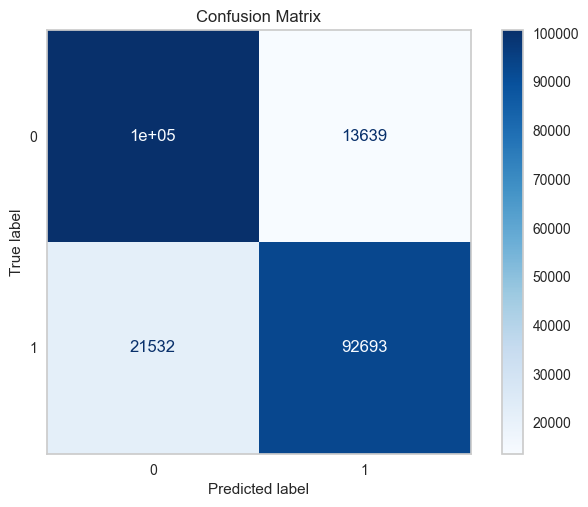

In [62]:
test_metrics = ml.evaluate_model(bal_model, X_test_scaled, y_test)


 Metrics across thresholds:
   Threshold     TPR     FPR  Precision  Error Rate  G Score  F1 Score     FNR
0       0.10  0.9810  0.4721     0.6751      0.2456   0.7196    0.7998  0.0190
1       0.20  0.9521  0.3248     0.7456      0.1863   0.8018    0.8363  0.0479
2       0.35  0.9152  0.2358     0.7951      0.1603   0.8363    0.8509  0.0848
3       0.50  0.8683  0.1697     0.8365      0.1507   0.8491    0.8521  0.1317


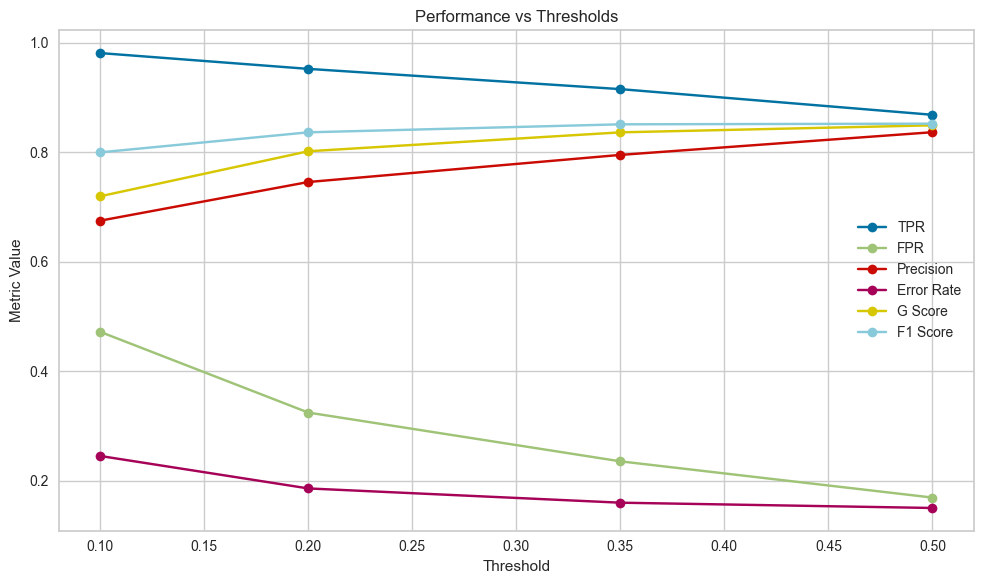

In [63]:
threshold_df = ml.evaluate_thresholds(bal_model, X_test_scaled, y_test, thresholds=[0.1, 0.2, 0.35, 0.5])
ml.plot_metrics_vs_thresholds(threshold_df)

<h1> Bagging with RandomSearchCV Tuning  </h1>

In [64]:
model_type = "bag"
bal_model = ml.train_model(model_type, X_train_scaled, y_train, X_tune= X_train_scaled_tune, y_tune = y_train_tune, tune=True, n_iter = 10)  # tune=True enables tuning with option to choose RandomSearch or GridSearch

Tuning combinations received, moving to model fitting ...

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_features=0.75, max_samples=0.75, n_estimators=20; total time= 2.0min
[CV] END max_features=0.75, max_samples=0.75, n_estimators=20; total time= 2.0min
[CV] END max_features=0.75, max_samples=0.75, n_estimators=20; total time= 2.0min
[CV] END .max_features=0.5, max_samples=1.0, n_estimators=30; total time= 2.5min
[CV] END .max_features=0.5, max_samples=1.0, n_estimators=30; total time= 2.5min
[CV] END .max_features=0.5, max_samples=1.0, n_estimators=30; total time= 2.5min
[CV] END .max_features=0.5, max_samples=1.0, n_estimators=30; total time= 2.5min
[CV] END .max_features=0.5, max_samples=1.0, n_estimators=30; total time= 2.5min
[CV] END max_features=0.75, max_samples=0.5, n_estimators=10; total time=  44.0s
[CV] END max_features=0.75, max_samples=0.5, n_estimators=10; total time=  39.4s
[CV] END max_features=0.75, max_samples=0.5, n_estimators=10; total


 Test Set Evaluation:
Accuracy:  0.8753
Precision: 0.8784
Recall:    0.8711
F1 Score:  0.8748


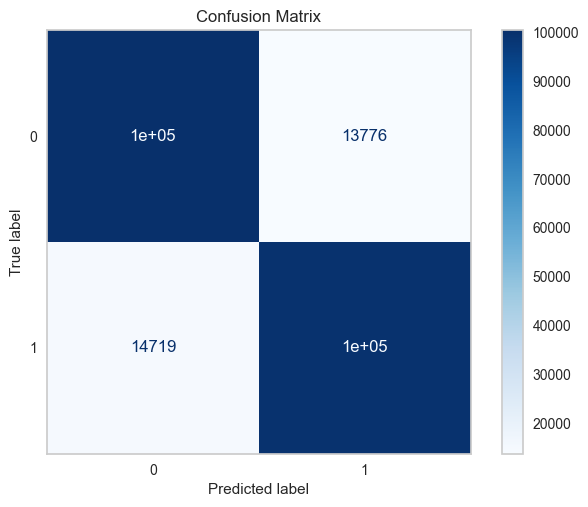

In [65]:
test_metrics = ml.evaluate_model(bal_model, X_test_scaled, y_test)

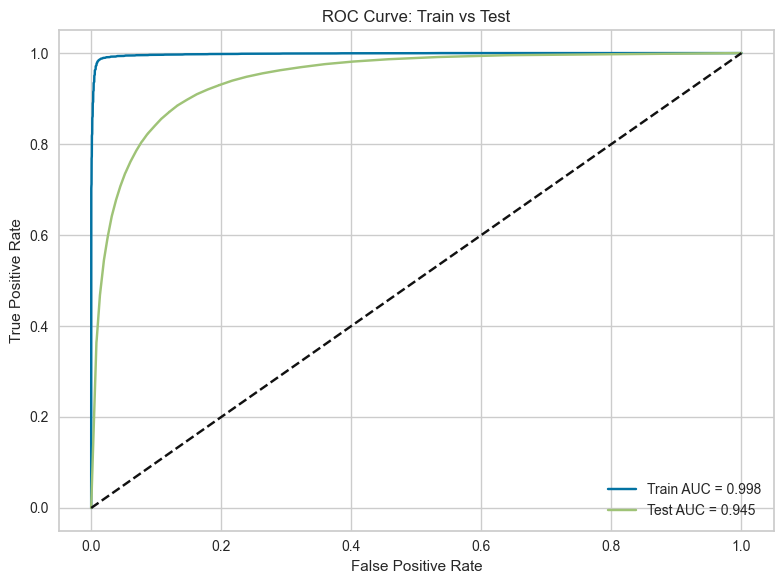

In [66]:
ml.plot_roc_train_vs_test(bal_model, X_train_scaled, y_train, X_test_scaled, y_test)


 Metrics across thresholds:
   Threshold     TPR     FPR  Precision  Error Rate  G Score  F1 Score     FNR
0       0.10  0.9855  0.4470     0.6880      0.2307   0.7383    0.8103  0.0145
1       0.20  0.9681  0.3178     0.7528      0.1749   0.8127    0.8470  0.0319
2       0.35  0.9291  0.1958     0.8259      0.1334   0.8644    0.8745  0.0709
3       0.50  0.8829  0.1308     0.8709      0.1240   0.8760    0.8769  0.1171


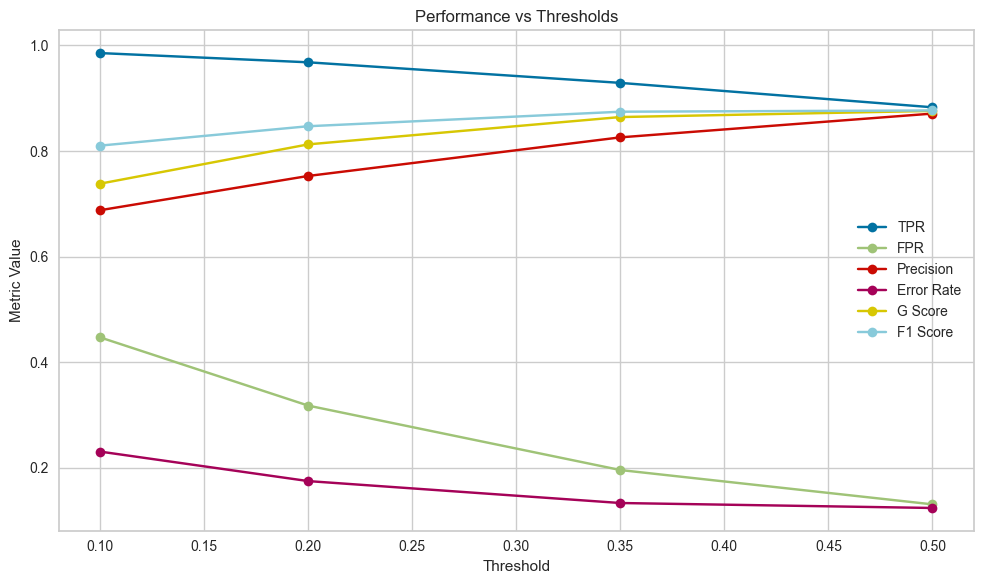

In [67]:
threshold_df = ml.evaluate_thresholds(bal_model, X_test_scaled, y_test, thresholds=[0.1, 0.2, 0.35, 0.5])
ml.plot_metrics_vs_thresholds(threshold_df)

## Supervised Machine Learning using 3 PC's and 5 Clusters 
#### 3 PCs explain 43% of the variance and 5 clusters were reccomended alongside this

In [68]:
pca_cluster_data = pca_cluster_df

In [69]:
tuning_subsample = pca_cluster_data

In [70]:
X_train, X_test, X_train_scaled, X_test_scaled, y_train, y_test, feature_names = ml.preprocess_data(pca_cluster_data)

 Applied SMOTE: Resampled class distribution: {1: 266526, 0: 266526}


In [71]:
X_train_tune, X_test_tune, X_train_scaled_tune, X_test_scaled_tune, y_train_tune, y_test_tune, feature_names = ml.preprocess_data(tuning_subsample, smote = False)  # this does not include smote sampling - the tuning set is not balance

#### Random Forest with RandomSearchCV Tuning and Balanced Data¶

In [72]:
model_type = 'rf'  # or 'xgb'
bal_model = ml.train_model(model_type, X_train_scaled, y_train, X_tune= X_train_scaled_tune, y_tune = y_train_tune, tune=True, n_iter = 20)  # tune=True enables RandomizedSearchCV for RF

Tuning combinations received, moving to model fitting ...

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time= 2.0min
[CV] END max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time= 2.0min
[CV] END max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time= 2.0min
[CV] END max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time= 2.0min
[CV] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 2.0min
[CV] END max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time= 2.0min
[CV] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 2.0min
[CV] END max_depth=10, max_feature

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Python(37492) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time= 2.2min
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time= 2.2min
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time= 2.1min
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time= 2.1min
[CV] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time= 5.9min
[CV] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time= 5.9min
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time= 2.2min
[CV] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time= 5.8min
[CV] END max_depth=10, max_features=l


 Test Set Evaluation:
Accuracy:  0.8575
Precision: 0.8538
Recall:    0.8628
F1 Score:  0.8583


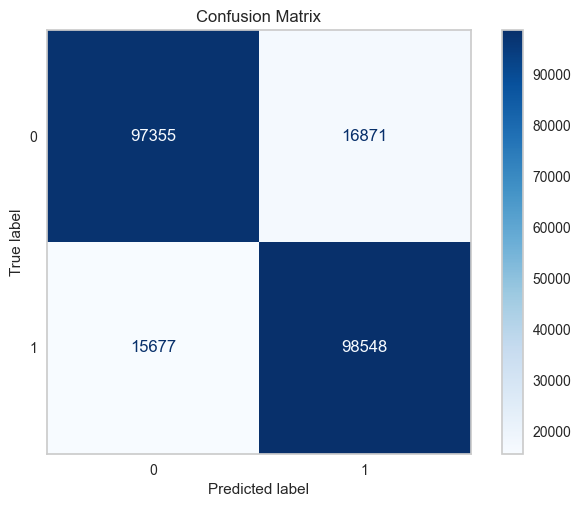

In [73]:
test_metrics = ml.evaluate_model(bal_model, X_test_scaled, y_test)

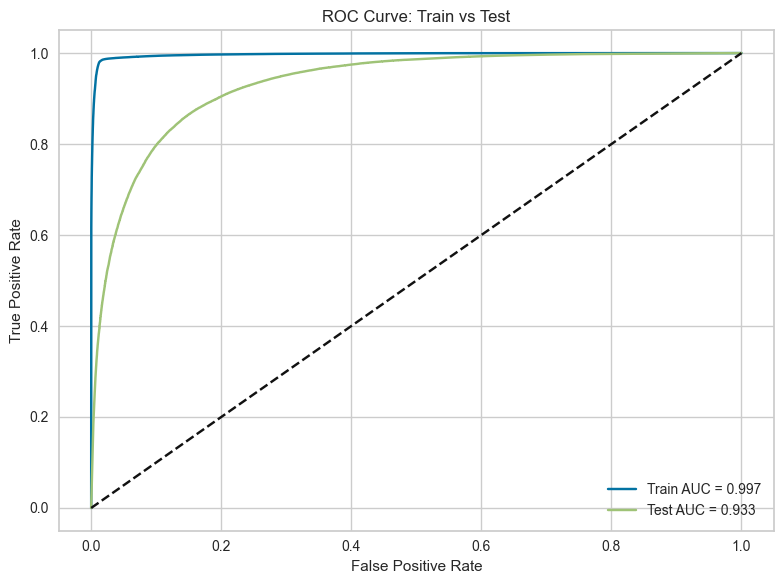

In [74]:
ml.plot_roc_train_vs_test(bal_model, X_train_scaled, y_train, X_test_scaled, y_test)


 Metrics across thresholds:
   Threshold     TPR     FPR  Precision  Error Rate  G Score  F1 Score     FNR
0       0.10  0.9802  0.4356     0.6923      0.2277   0.7438    0.8115  0.0198
1       0.20  0.9595  0.3274     0.7456      0.1839   0.8034    0.8391  0.0405
2       0.35  0.9183  0.2222     0.8052      0.1519   0.8452    0.8581  0.0817
3       0.50  0.8628  0.1477     0.8538      0.1425   0.8575    0.8583  0.1372


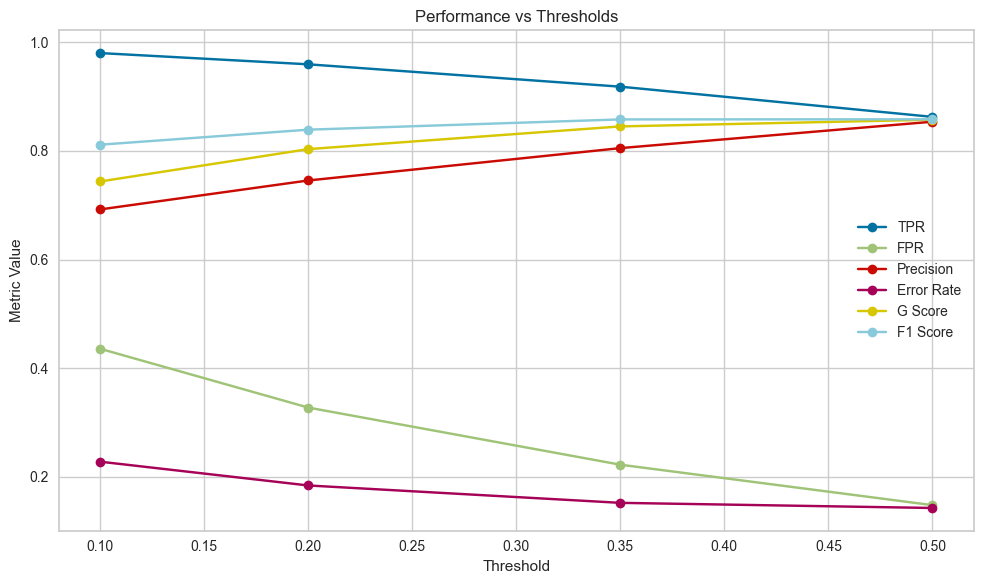

In [75]:
threshold_df = ml.evaluate_thresholds(bal_model, X_test_scaled, y_test, thresholds=[0.1, 0.2, 0.35, 0.5])
ml.plot_metrics_vs_thresholds(threshold_df)

#### XGBoost with RandomSearchCV Tuning

In [76]:
model_type = 'xgb'  
bal_model = ml.train_model(model_type, X_train_scaled, y_train,X_tune= X_train_scaled_tune, y_tune = y_train_tune, tune=True, n_iter= 20, scoring = "recall")  # tune=True enables tuning with option to choose RandomSearch or GridSearch

Tuning combinations received, moving to model fitting ...

Fitting 5 folds for each of 20 candidates, totalling 100 fits


Python(38085) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(38086) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(38087) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(38088) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(38089) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(38090) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(38091) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(38092) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=1; total time=   5.9s
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=1; total time=   5.9s
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=1; total time=   6.0s
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=1; total time=   6.1s
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=1; total time=   6.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.8; total time=   9.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.8; total time=   9.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.8; total time=  10.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.8; 


 Test Set Evaluation:
Accuracy:  0.7996
Precision: 0.7938
Recall:    0.8093
F1 Score:  0.8015


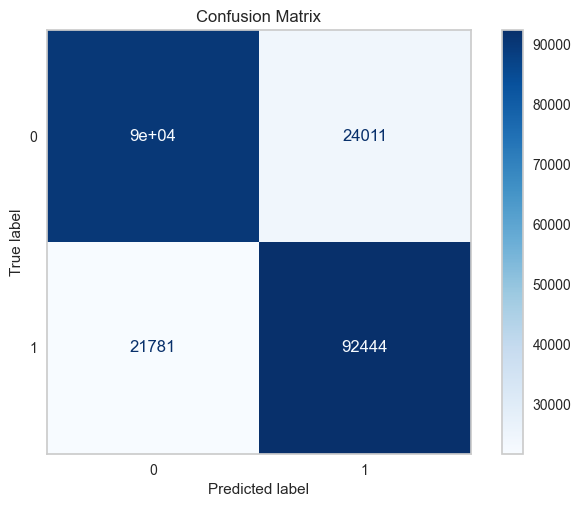

In [77]:
test_metrics = ml.evaluate_model(bal_model, X_test_scaled, y_test)

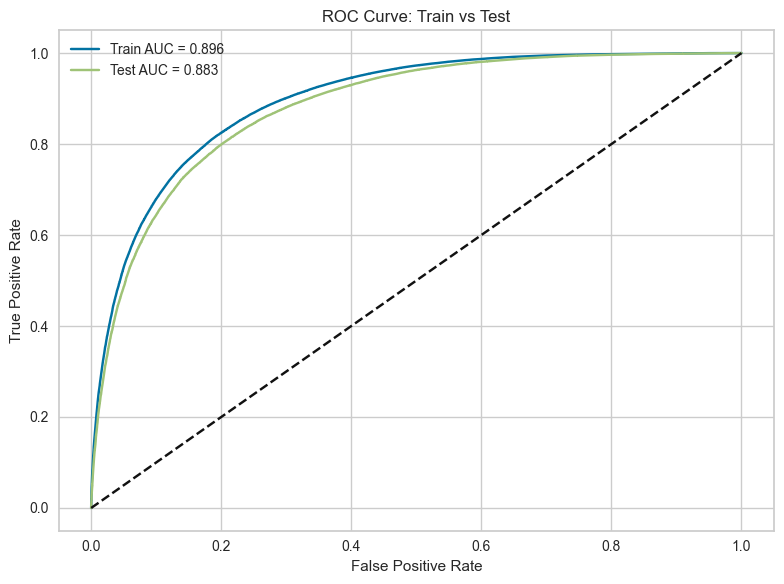

In [78]:
ml.plot_roc_train_vs_test(bal_model, X_train_scaled, y_train, X_test_scaled, y_test)


 Metrics across thresholds:
   Threshold     TPR     FPR  Precision  Error Rate  G Score  F1 Score     FNR
0       0.10  0.9902  0.6881     0.5900      0.3490   0.5557    0.7394  0.0098
1       0.20  0.9724  0.5465     0.6402      0.2871   0.6641    0.7721  0.0276
2       0.35  0.9119  0.3574     0.7184      0.2227   0.7655    0.8037  0.0881
3       0.50  0.8093  0.2102     0.7938      0.2004   0.7995    0.8015  0.1907


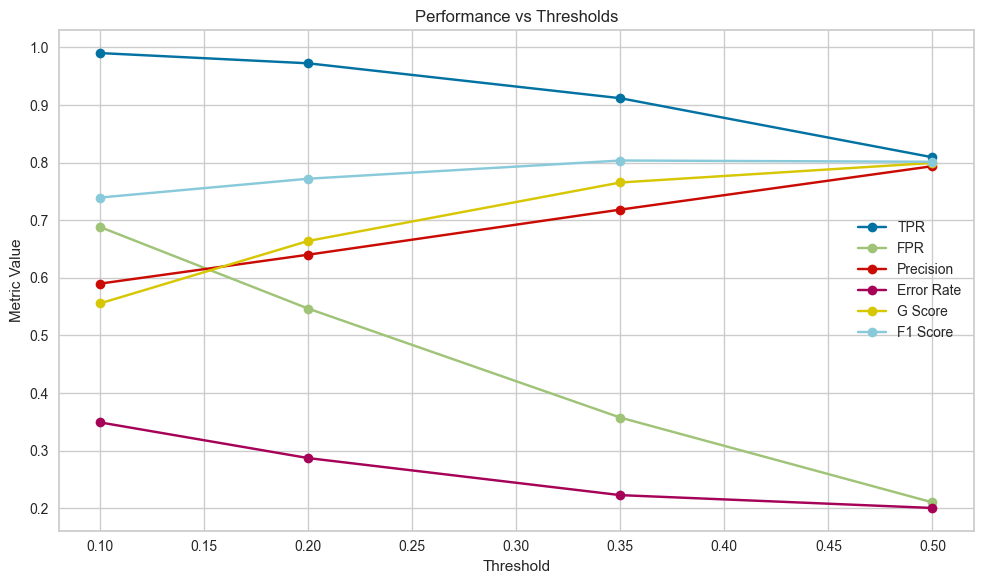

In [79]:
threshold_df = ml.evaluate_thresholds(bal_model, X_test_scaled, y_test, thresholds=[0.1, 0.2, 0.35, 0.5])
ml.plot_metrics_vs_thresholds(threshold_df)

## KNN

In [80]:
model_type = 'knn'
bal_model = ml.train_model(model_type, X_train_scaled, y_train, X_tune= X_train_scaled_tune, y_tune = y_train_tune, tune=True, n_iter = 10, scoring= "roc_auc")

Tuning combinations received, moving to model fitting ...

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END .....................................n_neighbors=10; total time=   2.4s
[CV] END .....................................n_neighbors=10; total time=   2.4s
[CV] END .....................................n_neighbors=11; total time=   2.4s
[CV] END .....................................n_neighbors=10; total time=   2.5s
[CV] END .....................................n_neighbors=11; total time=   2.5s
[CV] END .....................................n_neighbors=11; total time=   2.5s
[CV] END .....................................n_neighbors=11; total time=   2.5s
[CV] END .....................................n_neighbors=11; total time=   2.6s
[CV] END ......................................n_neighbors=1; total time=   1.6s
[CV] END ......................................n_neighbors=1; total time=   1.6s
[CV] END ......................................n_neighbors=1; total ti


 Test Set Evaluation:
Accuracy:  0.8370
Precision: 0.8402
Recall:    0.8324
F1 Score:  0.8363


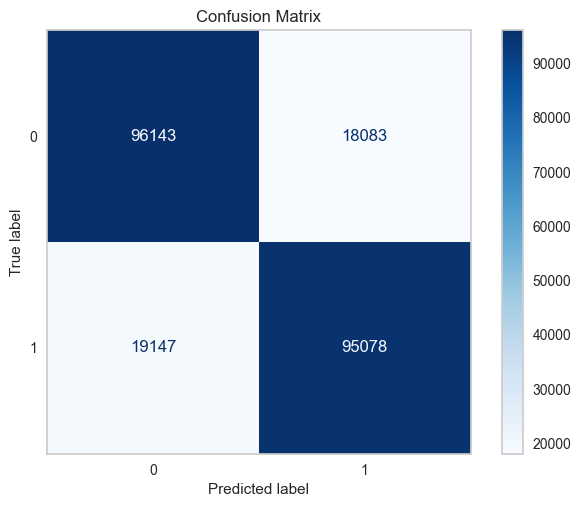

In [81]:
test_metrics = ml.evaluate_model(bal_model, X_test_scaled, y_test)


 Metrics across thresholds:
   Threshold     TPR     FPR  Precision  Error Rate  G Score  F1 Score     FNR
0       0.10  0.9822  0.5024     0.6616      0.2601   0.6991    0.7906  0.0178
1       0.20  0.9567  0.3646     0.7240      0.2040   0.7797    0.8243  0.0433
2       0.35  0.8824  0.2125     0.8059      0.1650   0.8336    0.8424  0.1176
3       0.50  0.8324  0.1583     0.8402      0.1630   0.8370    0.8363  0.1676


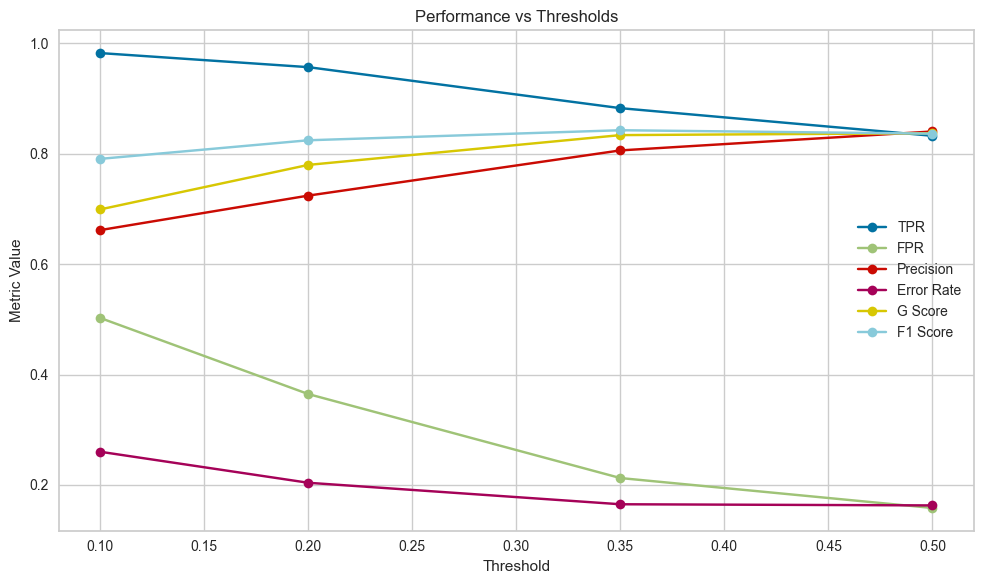

In [82]:
threshold_df = ml.evaluate_thresholds(bal_model, X_test_scaled, y_test, thresholds=[0.1, 0.2, 0.35, 0.5])
ml.plot_metrics_vs_thresholds(threshold_df)

## Bagging

In [83]:
model_type = "bag"
bal_model = ml.train_model(model_type, X_train_scaled, y_train, X_tune= X_train_scaled_tune, y_tune = y_train_tune, tune=True, n_iter = 10)  # tune=True enables tuning with option to choose RandomSearch or GridSearch

Tuning combinations received, moving to model fitting ...

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_features=0.75, max_samples=0.75, n_estimators=20; total time=  37.6s
[CV] END max_features=0.75, max_samples=0.75, n_estimators=20; total time=  38.1s
[CV] END max_features=0.75, max_samples=0.75, n_estimators=20; total time=  38.3s
[CV] END max_features=0.75, max_samples=0.5, n_estimators=10; total time=  13.7s
[CV] END .max_features=0.5, max_samples=1.0, n_estimators=30; total time=  58.0s
[CV] END .max_features=0.5, max_samples=1.0, n_estimators=30; total time=  58.1s
[CV] END .max_features=0.5, max_samples=1.0, n_estimators=30; total time=  58.7s
[CV] END .max_features=0.5, max_samples=1.0, n_estimators=30; total time=  59.0s
[CV] END .max_features=0.5, max_samples=1.0, n_estimators=30; total time=  59.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Python(38153) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[CV] END max_features=0.75, max_samples=0.5, n_estimators=10; total time=  14.3s
[CV] END max_features=0.75, max_samples=0.5, n_estimators=10; total time=  14.1s
[CV] END max_features=0.75, max_samples=0.5, n_estimators=10; total time=  14.6s
[CV] END max_features=0.75, max_samples=0.5, n_estimators=10; total time=  14.4s
[CV] END max_features=0.75, max_samples=0.75, n_estimators=20; total time=  39.6s
[CV] END max_features=0.75, max_samples=0.75, n_estimators=20; total time=  39.6s
[CV] END .max_features=0.5, max_samples=0.5, n_estimators=10; total time=  12.3s
[CV] END max_features=1.0, max_samples=0.75, n_estimators=10; total time=  26.6s
[CV] END max_features=1.0, max_samples=0.75, n_estimators=10; total time=  26.2s
[CV] END .max_features=0.5, max_samples=0.5, n_estimators=10; total time=  12.2s
[CV] END .max_features=0.5, max_samples=0.5, n_estimators=10; total time=  12.2s
[CV] END max_features=1.0, max_samples=0.75, n_estimators=10; total time=  26.1s
[CV] END .max_features=0.5


 Test Set Evaluation:
Accuracy:  0.8486
Precision: 0.8579
Recall:    0.8356
F1 Score:  0.8466


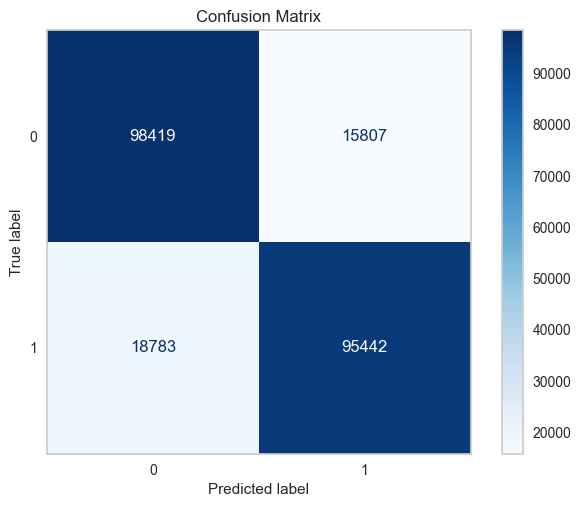

In [84]:
test_metrics = ml.evaluate_model(bal_model, X_test_scaled, y_test)

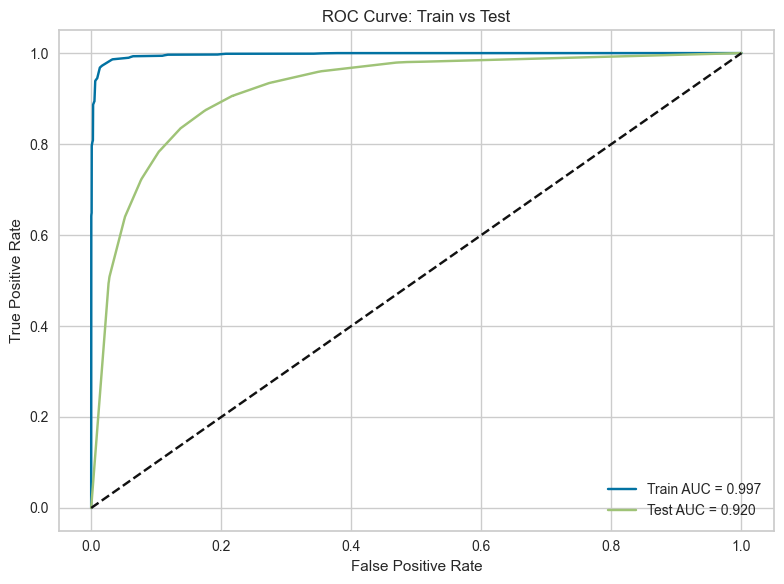

In [85]:
ml.plot_roc_train_vs_test(bal_model, X_train_scaled, y_train, X_test_scaled, y_test)


 Metrics across thresholds:
   Threshold     TPR     FPR  Precision  Error Rate  G Score  F1 Score     FNR
0       0.10  0.9787  0.4653     0.6778      0.2433   0.7234    0.8009  0.0213
1       0.20  0.9583  0.3471     0.7341      0.1944   0.7910    0.8313  0.0417
2       0.35  0.9065  0.2185     0.8058      0.1560   0.8417    0.8532  0.0935
3       0.50  0.8702  0.1713     0.8355      0.1505   0.8492    0.8525  0.1298


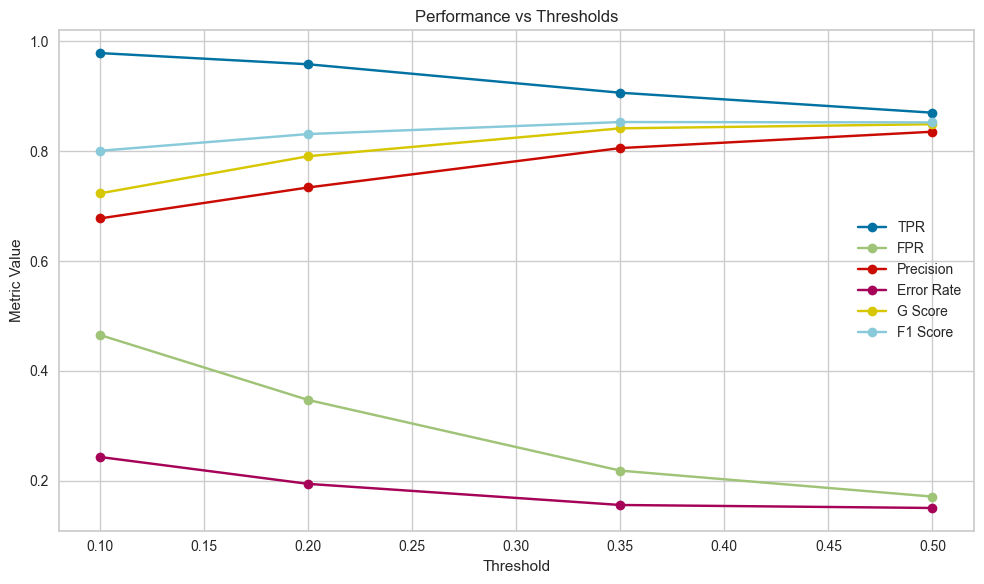

In [86]:
threshold_df = ml.evaluate_thresholds(bal_model, X_test_scaled, y_test, thresholds=[0.1, 0.2, 0.35, 0.5])
ml.plot_metrics_vs_thresholds(threshold_df)

## Now Trying 9 PCs and 2 clusters

In [41]:
# Extract all 3 principal components for clustering
X_pca_only = pca_df9[[f'PC{i}' for i in range(1, 9)]]

# Fit KMeans on the full PCA-reduced data
kmeans = KMeans(n_clusters=2, init='k-means++', random_state=220)
kmeans_labels = kmeans.fit_predict(X_pca_only)

# Add cluster labels to the DataFrame
pca_df9['cluster_label'] = kmeans_labels

# One-hot encode the cluster labels
pca_cluster9_df = pd.get_dummies(pca_df9, columns=['cluster_label'], prefix='cluster')

In [42]:
pca_cluster9_data = pca_cluster9_df

C:\Users\caoimhin\AppData\Local\Temp\ipykernel_10192\4223286932.py:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(scatter, label='Cluster')


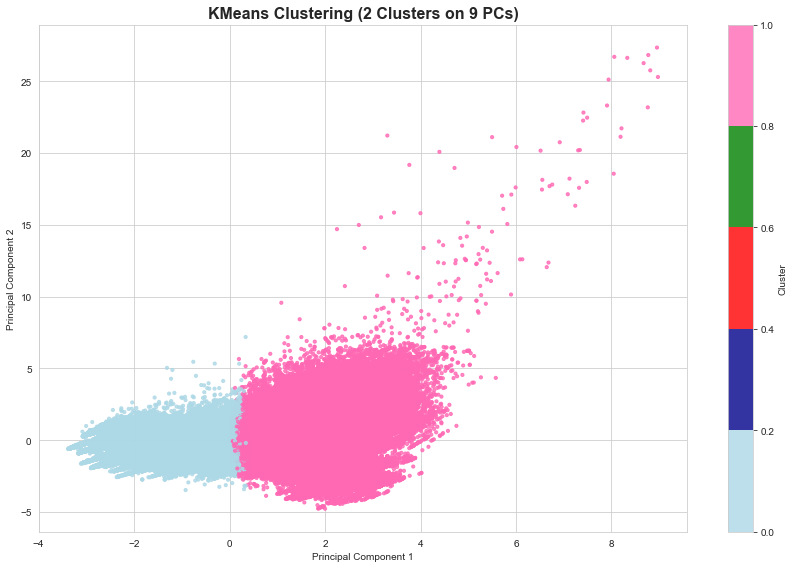

In [44]:
# 2D plot using PC1 and PC2
from matplotlib.colors import ListedColormap
cluster_colors = ListedColormap(['#ADD8E6','#00008B','#FF0000','#008000', '#FF69B4'])
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    pca_cluster9_data['PC1'], pca_cluster9_data['PC2'],
    c=pca_df9['cluster_label'], cmap=cluster_colors, s=10, alpha=0.8
)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KMeans Clustering (2 Clusters on 9 PCs)', fontsize=16, fontweight='bold')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

In [89]:
pca_cluster9_data.to_csv('pca_cluster9_data.csv')

In [90]:
pca_cluster9_data['cluster_label'] = pca_cluster9_data[['cluster_0', 'cluster_1']]\
    .idxmax(axis=1).str.extract('(\d)').astype(int)

# Drop the one-hot columns
pca_cluster9_data.drop(columns=['cluster_0', 'cluster_1'], inplace=True)
pca_cluster9_data

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
/var/folders/sy/bxcftcdx75n3w7kv3ljkq2p40000gn/T/ipykernel_31042/1730728894.py:2: SyntaxWarning: invalid escape sequence '\d'
  .idxmax(axis=1).str.extract('(\d)').astype(int)


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,Default,cluster_label
0,-2.212630,0.739698,0.471877,0.376789,0.873683,-0.657240,0.392078,-0.262658,-0.535535,0,0
1,-1.997808,0.260432,-1.044656,1.021606,0.432102,-0.473718,-0.364218,0.553780,-0.547772,0,0
2,-1.091734,0.633304,-0.049870,0.445465,-1.203342,0.059681,0.794638,0.999269,0.071901,0,0
3,-2.171384,0.501243,-0.555358,0.555726,-1.542175,-0.021661,0.014429,0.678782,-0.597317,1,0
4,-1.831272,0.736598,-1.140062,0.089103,-1.633314,0.460529,-0.626720,-0.886787,-0.241792,1,0
...,...,...,...,...,...,...,...,...,...,...,...
761497,-2.096222,0.058786,-1.091745,0.672871,0.289068,-0.820494,-0.360304,0.502550,-0.521387,1,0
761498,1.189576,0.401931,-1.193095,-0.190201,0.438609,-0.328021,-0.211218,-0.478139,0.499528,1,1
761499,-2.251292,0.998584,0.197738,-0.211980,-1.105712,0.514858,0.264339,-1.840104,-0.067400,1,0
761500,-0.294733,-1.128929,0.361743,0.447034,0.792617,-0.555874,0.356102,0.324763,-1.132014,1,0


## Random Forest with Random Search CV Tunning

In [91]:
tuning_subsample = pca_cluster9_data

In [92]:
X_train, X_test, X_train_scaled, X_test_scaled, y_train, y_test, feature_names = ml.preprocess_data(pca_cluster9_data)

 Applied SMOTE: Resampled class distribution: {1: 266526, 0: 266526}


In [93]:
X_train_tune, X_test_tune, X_train_scaled_tune, X_test_scaled_tune, y_train_tune, y_test_tune, feature_names = ml.preprocess_data(tuning_subsample)  # this does not include smote sampling - the tuning set is not balance

 Applied SMOTE: Resampled class distribution: {1: 266526, 0: 266526}


In [94]:
model_type = 'rf'  # or 'xgb'
bal_model = ml.train_model(model_type, X_train_scaled, y_train, X_tune= X_train_scaled_tune, y_tune = y_train_tune, tune=True, n_iter = 20)  # tune=True enables RandomizedSearchCV for RF

Tuning combinations received, moving to model fitting ...

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time= 2.9min
[CV] END max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time= 2.9min
[CV] END max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time= 2.9min
[CV] END max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time= 3.0min
[CV] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 3.0min
[CV] END max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time= 3.0min
[CV] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 3.0min
[CV] END max_depth=10, max_feature


 Test Set Evaluation:
Accuracy:  0.8774
Precision: 0.8763
Recall:    0.8788
F1 Score:  0.8776


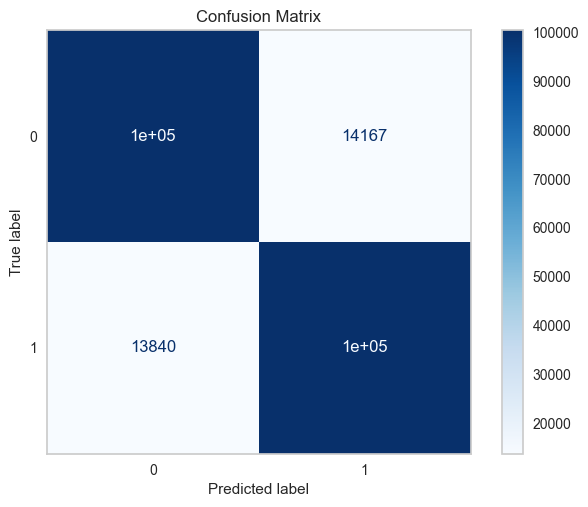

In [95]:
test_metrics = ml.evaluate_model(bal_model, X_test_scaled, y_test)

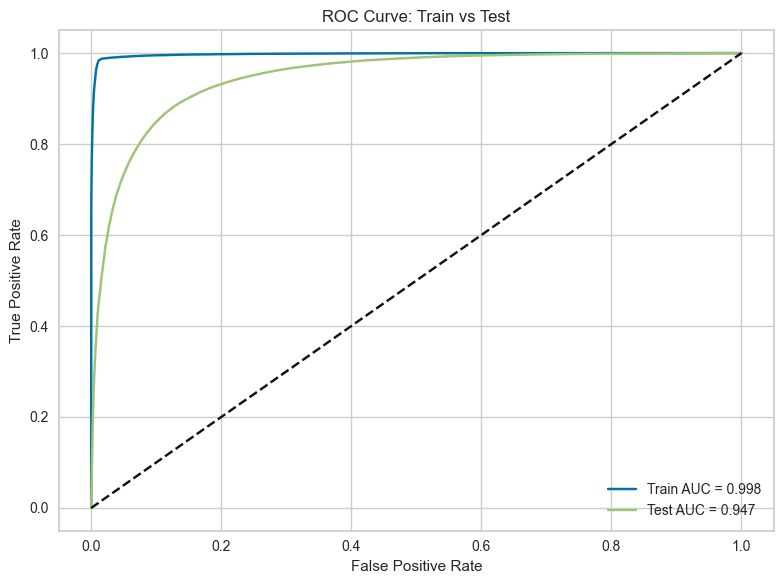

In [96]:
ml.plot_roc_train_vs_test(bal_model, X_train_scaled, y_train, X_test_scaled, y_test)


 Metrics across thresholds:
   Threshold     TPR     FPR  Precision  Error Rate  G Score  F1 Score     FNR
0       0.10  0.9833  0.4177     0.7019      0.2172   0.7567    0.8191  0.0167
1       0.20  0.9651  0.2992     0.7634      0.1670   0.8224    0.8525  0.0349
2       0.35  0.9287  0.1938     0.8273      0.1326   0.8653    0.8751  0.0713
3       0.50  0.8788  0.1240     0.8763      0.1226   0.8774    0.8776  0.1212


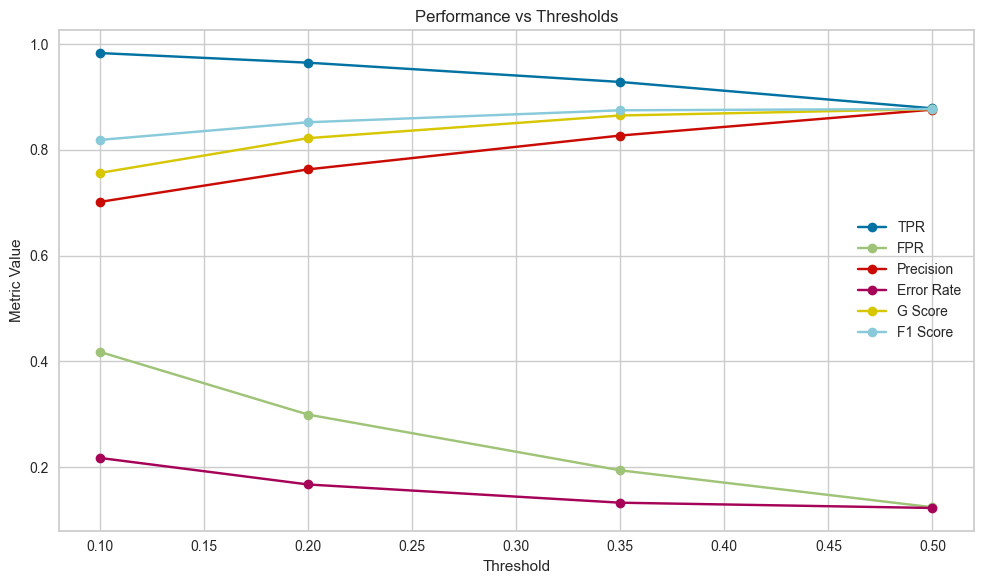

In [97]:
threshold_df = ml.evaluate_thresholds(bal_model, X_test_scaled, y_test, thresholds=[0.1, 0.2, 0.35, 0.5])
ml.plot_metrics_vs_thresholds(threshold_df)

## XGBoost with RandomSearchCV Tuning

In [98]:
model_type = 'xgb'  
bal_model = ml.train_model(model_type, X_train_scaled, y_train,X_tune= X_train_scaled_tune, y_tune = y_train_tune, tune=True, n_iter= 20, scoring = "recall")  # tune=True enables tuning with option to choose RandomSearch or GridSearch

Tuning combinations received, moving to model fitting ...

Fitting 5 folds for each of 20 candidates, totalling 100 fits


Python(41835) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(41836) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(41837) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(41838) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(41839) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(41841) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(41842) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(41843) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=1; total time=   9.2s
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=1; total time=   9.6s
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=1; total time=   9.7s
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=1; total time=   9.8s
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=1; total time=   9.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.8; total time=  15.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.8; total time=  15.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.8; total time=  15.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.8; 


 Test Set Evaluation:
Accuracy:  0.8298
Precision: 0.8250
Recall:    0.8373
F1 Score:  0.8311


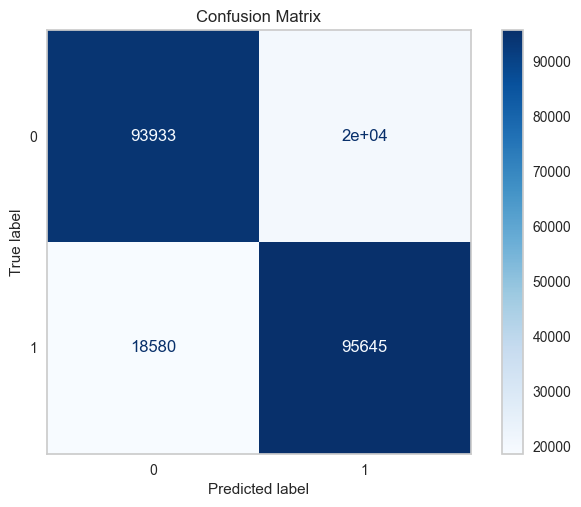

In [99]:
test_metrics = ml.evaluate_model(bal_model, X_test_scaled, y_test)

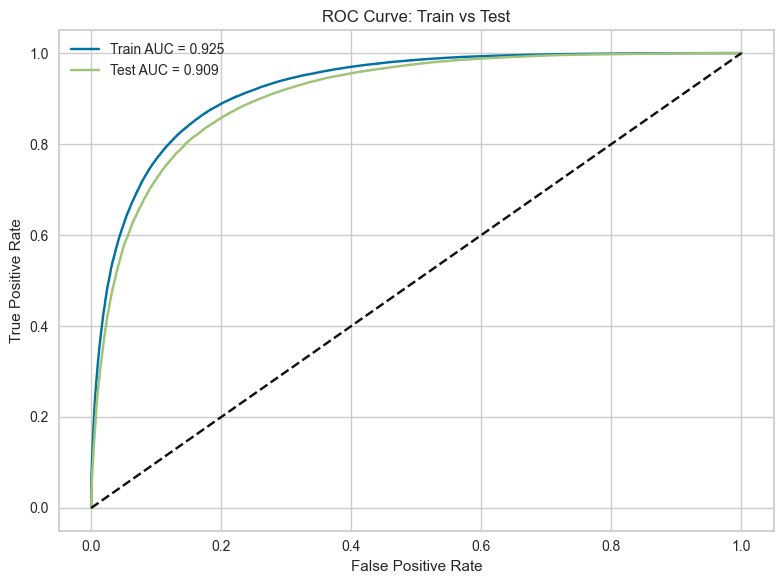

In [100]:
ml.plot_roc_train_vs_test(bal_model, X_train_scaled, y_train, X_test_scaled, y_test)


 Metrics across thresholds:
   Threshold     TPR     FPR  Precision  Error Rate  G Score  F1 Score     FNR
0       0.10  0.9891  0.6154     0.6165      0.3132   0.6168    0.7595  0.0109
1       0.20  0.9689  0.4610     0.6776      0.2461   0.7226    0.7975  0.0311
2       0.35  0.9146  0.2876     0.7608      0.1865   0.8072    0.8306  0.0854
3       0.50  0.8373  0.1777     0.8250      0.1702   0.8298    0.8311  0.1627


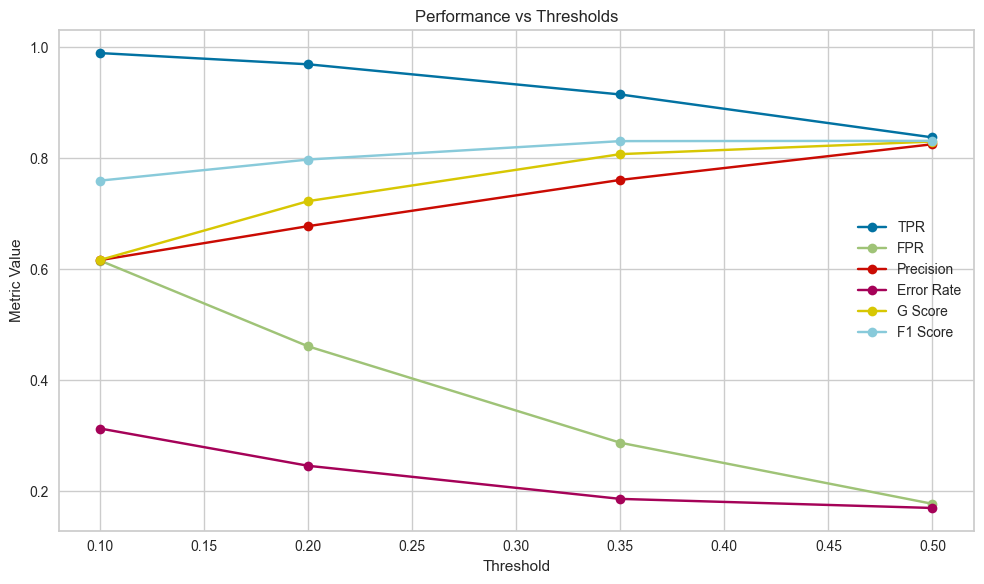

In [101]:
threshold_df = ml.evaluate_thresholds(bal_model, X_test_scaled, y_test, thresholds=[0.1, 0.2, 0.35, 0.5])
ml.plot_metrics_vs_thresholds(threshold_df)

## KNN

In [102]:
model_type = 'knn'
bal_model = ml.train_model(model_type, X_train_scaled, y_train, X_tune= X_train_scaled_tune, y_tune = y_train_tune, tune=True, n_iter = 10, scoring= "roc_auc")

Tuning combinations received, moving to model fitting ...

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END .....................................n_neighbors=10; total time=   5.2s
[CV] END .....................................n_neighbors=10; total time=   5.2s
[CV] END .....................................n_neighbors=11; total time=   5.4s
[CV] END .....................................n_neighbors=11; total time=   5.4s
[CV] END .....................................n_neighbors=11; total time=   5.5s
[CV] END .....................................n_neighbors=11; total time=   5.5s
[CV] END .....................................n_neighbors=10; total time=   5.6s
[CV] END .....................................n_neighbors=11; total time=   5.7s
[CV] END ......................................n_neighbors=1; total time=   2.7s
[CV] END ......................................n_neighbors=1; total time=   2.8s
[CV] END ......................................n_neighbors=1; total ti


 Test Set Evaluation:
Accuracy:  0.8460
Precision: 0.8715
Recall:    0.8117
F1 Score:  0.8405


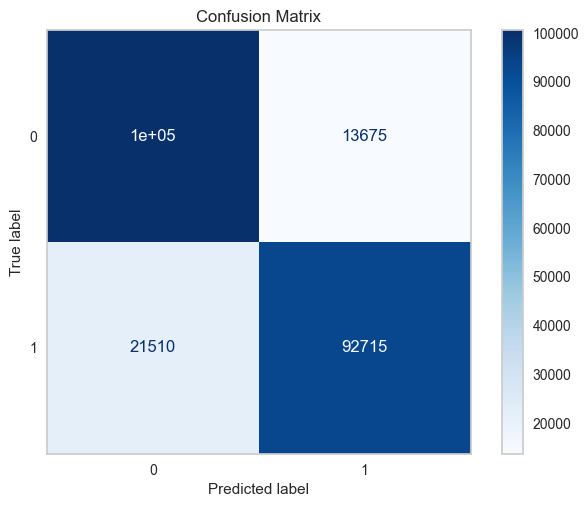

In [103]:
test_metrics = ml.evaluate_model(bal_model, X_test_scaled, y_test)


 Metrics across thresholds:
   Threshold     TPR     FPR  Precision  Error Rate  G Score  F1 Score     FNR
0       0.10  0.9810  0.4717     0.6753      0.2453   0.7199    0.7999  0.0190
1       0.20  0.9520  0.3248     0.7456      0.1864   0.8017    0.8362  0.0480
2       0.35  0.9152  0.2362     0.7948      0.1605   0.8361    0.8508  0.0848
3       0.50  0.8686  0.1702     0.8361      0.1508   0.8489    0.8520  0.1314


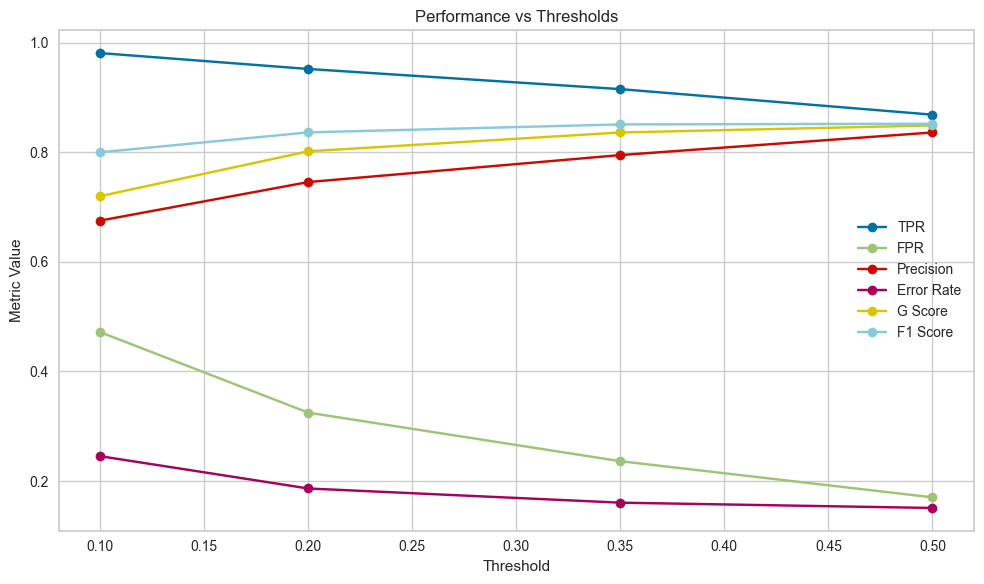

In [104]:
threshold_df = ml.evaluate_thresholds(bal_model, X_test_scaled, y_test, thresholds=[0.1, 0.2, 0.35, 0.5])
ml.plot_metrics_vs_thresholds(threshold_df)

## Bagging

In [105]:
model_type = "bag"
bal_model = ml.train_model(model_type, X_train_scaled, y_train, X_tune= X_train_scaled_tune, y_tune = y_train_tune, tune=True, n_iter = 10)  # tune=True enables tuning with option to choose RandomSearch or GridSearch

Tuning combinations received, moving to model fitting ...

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_features=0.75, max_samples=0.75, n_estimators=20; total time= 1.6min
[CV] END max_features=0.75, max_samples=0.75, n_estimators=20; total time= 1.6min
[CV] END max_features=0.75, max_samples=0.75, n_estimators=20; total time= 1.6min
[CV] END .max_features=0.5, max_samples=1.0, n_estimators=30; total time= 2.2min
[CV] END .max_features=0.5, max_samples=1.0, n_estimators=30; total time= 2.2min
[CV] END .max_features=0.5, max_samples=1.0, n_estimators=30; total time= 2.2min
[CV] END .max_features=0.5, max_samples=1.0, n_estimators=30; total time= 2.2min
[CV] END .max_features=0.5, max_samples=1.0, n_estimators=30; total time= 2.2min
[CV] END max_features=0.75, max_samples=0.5, n_estimators=10; total time=  37.3s
[CV] END max_features=0.75, max_samples=0.5, n_estimators=10; total time=  35.9s
[CV] END max_features=0.75, max_samples=0.5, n_estimators=10; total


 Test Set Evaluation:
Accuracy:  0.8755
Precision: 0.8785
Recall:    0.8715
F1 Score:  0.8750


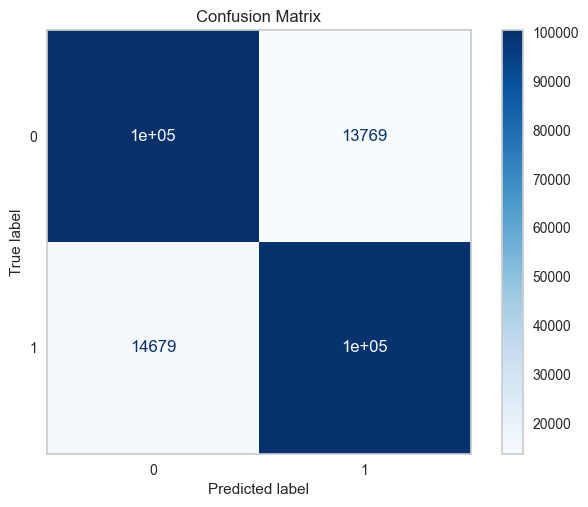

In [106]:
test_metrics = ml.evaluate_model(bal_model, X_test_scaled, y_test)

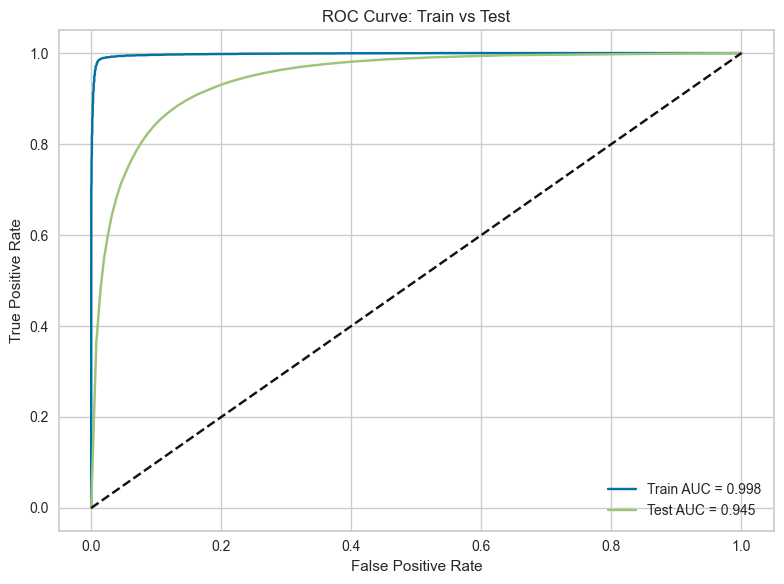

In [107]:
ml.plot_roc_train_vs_test(bal_model, X_train_scaled, y_train, X_test_scaled, y_test)


 Metrics across thresholds:
   Threshold     TPR     FPR  Precision  Error Rate  G Score  F1 Score     FNR
0       0.10  0.9854  0.4446     0.6891      0.2296   0.7398    0.8110  0.0146
1       0.20  0.9683  0.3163     0.7538      0.1740   0.8137    0.8477  0.0317
2       0.35  0.9282  0.1954     0.8261      0.1336   0.8641    0.8741  0.0718
3       0.50  0.8821  0.1307     0.8709      0.1243   0.8757    0.8765  0.1179


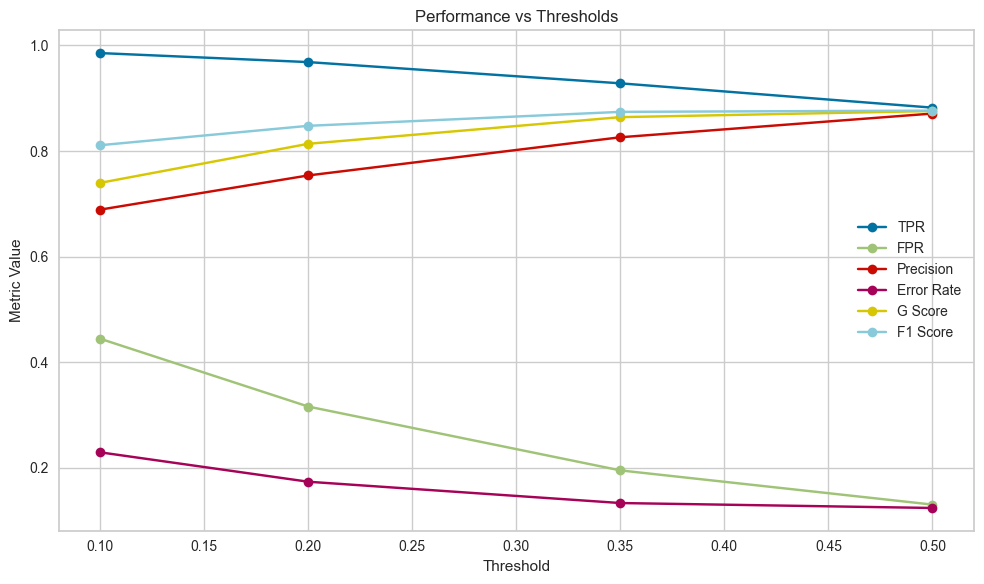

In [108]:
threshold_df = ml.evaluate_thresholds(bal_model, X_test_scaled, y_test, thresholds=[0.1, 0.2, 0.35, 0.5])
ml.plot_metrics_vs_thresholds(threshold_df)

## Hierachial Clustering 9 PCs

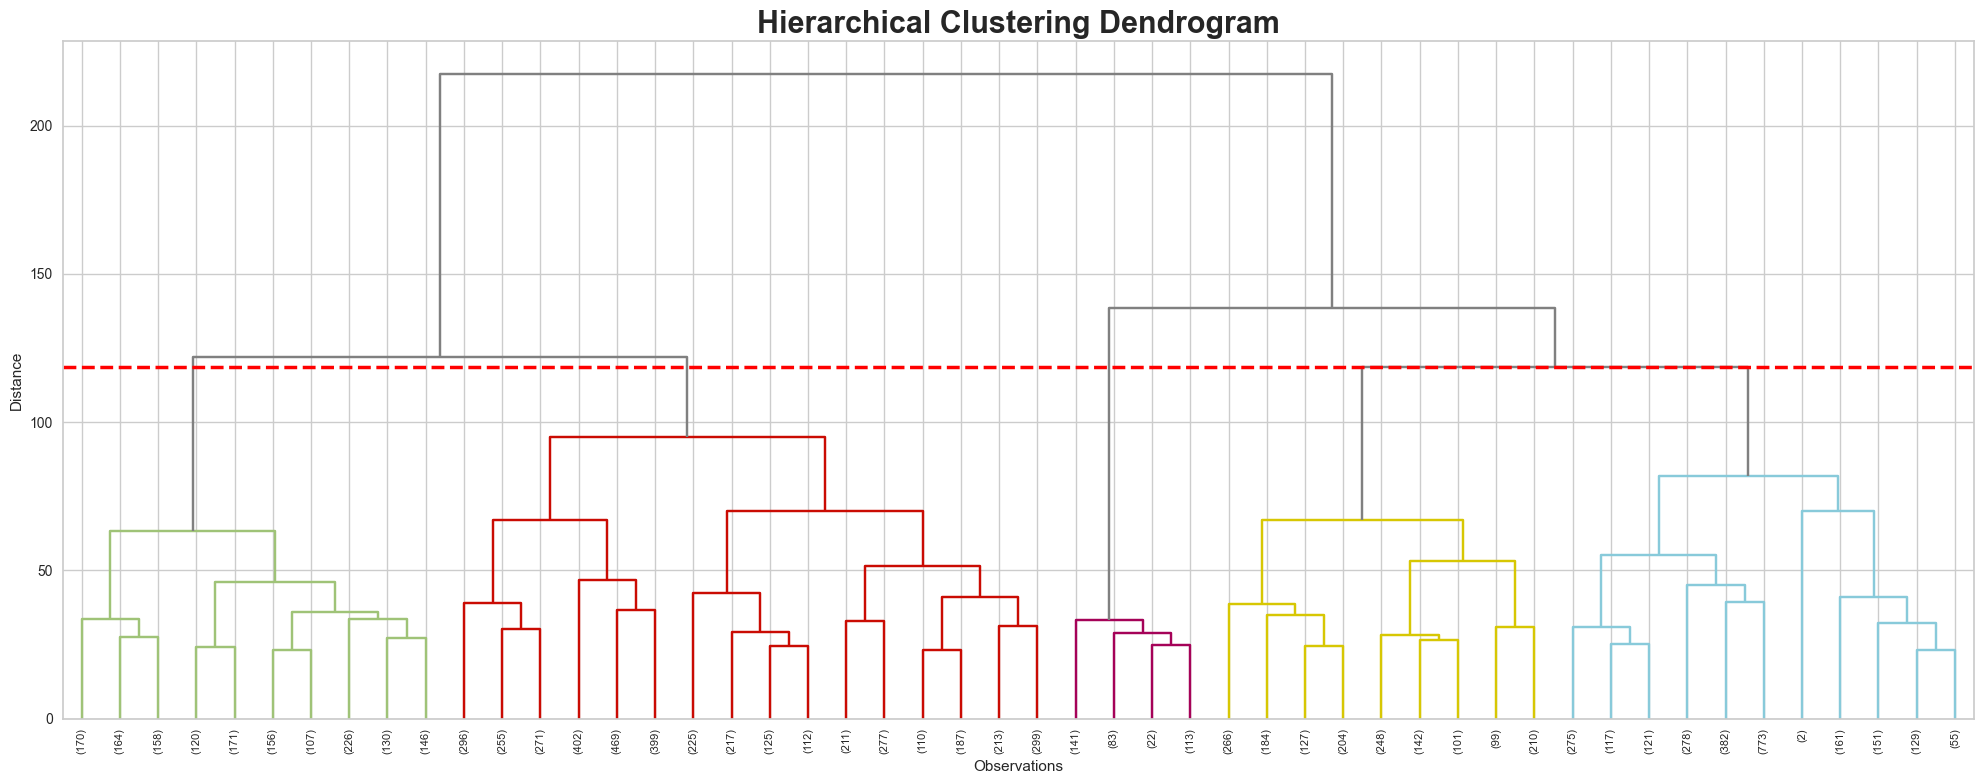

In [109]:
# --- Parameters ---
n_clusters = 5  
sample_size = 10000 
random_state = 10

# --- Step 1: Sample the PCA-reduced data ---
sampled_data = pca_data.sample(n=sample_size, random_state=random_state)

# --- Step 2: Compute the linkage matrix using Ward's method ---
linkage_matrix = linkage(sampled_data, method='ward')

# --- Step 3: Find the cut threshold based on number of clusters ---
max_d = linkage_matrix[-(n_clusters - 1), 2]  # Height to cut for n_clusters

# --- Step 4: Plot the dendrogram ---
plt.figure(figsize=(20, 8))
dendrogram(
    linkage_matrix,
    orientation='top',
    truncate_mode='lastp',
    p=50,
    show_leaf_counts=True,
    color_threshold=max_d - 1,
    above_threshold_color='grey'
)
plt.axhline(y=max_d, c='red', linestyle='--', linewidth=2.5)
plt.title('Hierarchical Clustering Dendrogram', fontsize=22, fontweight='bold')
plt.ylabel('Distance')
plt.xlabel('Observations')
plt.tight_layout()
plt.show()


In [25]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import calinski_harabasz_score

calinski_scores = []

# --- Sample the PCA data for speed ---
sampled_data = pca_data.sample(n=10000, random_state=10)

# --- Loop through different cluster numbers ---
for k in range(2, 7):  # Trying k = 2 to 6
    classifier = AgglomerativeClustering(
        n_clusters=k,
        affinity='euclidean',
        linkage='ward'
    )
    
    # Fit model and get predicted cluster labels
    y_pred = classifier.fit_predict(sampled_data)
    
    # Evaluate clustering quality
    score = calinski_harabasz_score(sampled_data, y_pred)

    # Save the result
    calinski_scores.append((k, score))

# --- Print the scores ---
print("Calinski-Harabasz Scores for different k values:")
for k, score in calinski_scores:
    print(f"k = {k}: Score = {score:.2f}")

Calinski-Harabasz Scores for different k values:
k = 2: Score = 1761.63
k = 3: Score = 1573.09
k = 4: Score = 1540.30
k = 5: Score = 1611.45
k = 6: Score = 1602.73


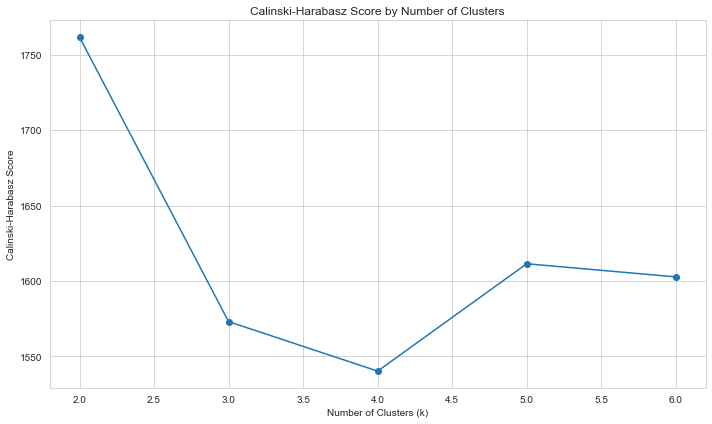

In [26]:
ks, scores = zip(*calinski_scores)
plt.plot(ks, scores, marker='o')
plt.title('Calinski-Harabasz Score by Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Calinski-Harabasz Score')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Shows that 2 Clusters is optimal when using 9 PCs

In [27]:
classifier = AgglomerativeClustering(n_clusters = 2, affinity = "euclidean", linkage = "ward")
y_pred = classifier.fit_predict(pca_data.sample(n= 10000, random_state = 10))

sampled_data["Cluster Label"] = y_pred

C:\Users\caoimhin\AppData\Local\Temp\ipykernel_10192\1368439243.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar().set_label('Cluster')


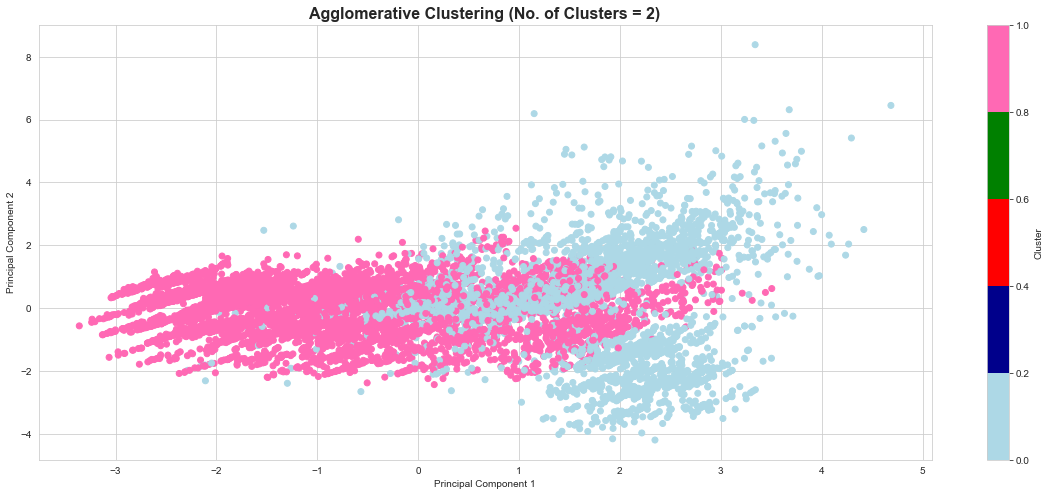

1    6484
0    3516
Name: Cluster Label, dtype: int64

In [39]:
plt.figure(figsize=(20, 8))
plt.scatter(sampled_data['PC1'], sampled_data['PC2'], c=sampled_data['Cluster Label'], cmap=cluster_colors)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Agglomerative Clustering (No. of Clusters = 2)', fontsize = 16, fontweight = 'bold')
plt.colorbar().set_label('Cluster')
plt.show()

sampled_data['Cluster Label'].value_counts()

C:\Users\caoimhin\AppData\Local\Temp\ipykernel_10192\1505418462.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  colour = fig.colorbar(scatter, ax=ax)


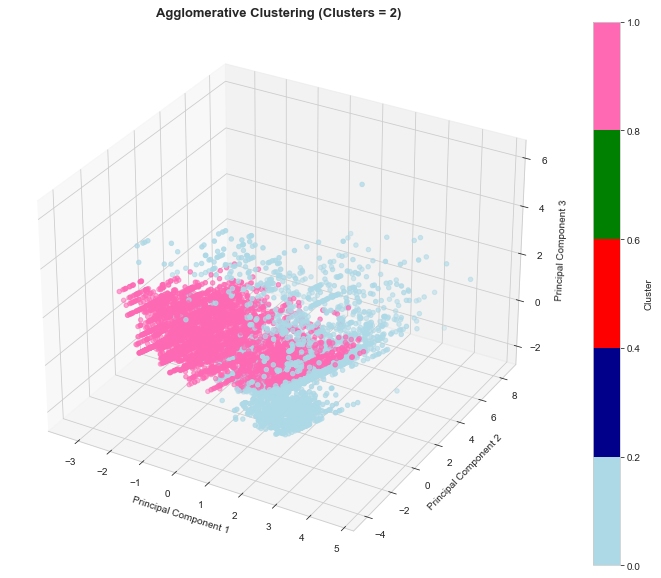

In [40]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(sampled_data['PC1'], sampled_data['PC2'], sampled_data['PC3'], c=sampled_data['Cluster Label'], cmap=cluster_colors)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('Agglomerative Clustering (Clusters = 2)', fontsize = '13', fontweight = 'bold')

colour = fig.colorbar(scatter, ax=ax)
colour.set_label('Cluster')

plt.show()

## Hierarchial Clustering 3 PCs

In [ ]:
# --- Parameters ---
n_clusters = 5  
sample_size = 10000 
random_state = 11

# --- Step 1: Sample the PCA-reduced data ---
sampled_data = pca_df3.sample(n=sample_size, random_state=random_state)

# --- Step 2: Compute the linkage matrix using Ward's method ---
linkage_matrix = linkage(sampled_data, method='ward')

# --- Step 3: Find the cut threshold based on number of clusters ---
max_d = linkage_matrix[-(n_clusters - 1), 2]  # Height to cut for n_clusters

# --- Step 4: Plot the dendrogram ---
plt.figure(figsize=(20, 8))
dendrogram(
    linkage_matrix,
    orientation='top',
    truncate_mode='lastp',
    p=50,
    show_leaf_counts=True,
    color_threshold=max_d - 1,
    above_threshold_color='grey'
)
plt.axhline(y=max_d, c='red', linestyle='--', linewidth=2.5)
plt.title('Hierarchical Clustering Dendrogram', fontsize=22, fontweight='bold')
plt.ylabel('Distance')
plt.xlabel('Observations')
plt.tight_layout()
plt.show()

In [ ]:
calinski_scores = []

# --- Sample the PCA data for speed ---
sampled_data = pca_df3.sample(n=10000, random_state=11)

# --- Loop through different cluster numbers ---
for k in range(2, 7):  # Trying k = 2 to 6
    classifier = AgglomerativeClustering(
        n_clusters=k,
        affinity='euclidean',
        linkage='ward'
    )
    
    # Fit model and get predicted cluster labels
    y_pred = classifier.fit_predict(sampled_data)
    
    # Evaluate clustering quality
    score = calinski_harabasz_score(sampled_data, y_pred)

    # Save the result
    calinski_scores.append((k, score))

# --- Print the scores ---
print("Calinski-Harabasz Scores for different k values:")
for k, score in calinski_scores:
    print(f"k = {k}: Score = {score:.2f}")

In [ ]:
ks, scores = zip(*calinski_scores)
plt.plot(ks, scores, marker='o')
plt.title('Calinski-Harabasz Score by Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Calinski-Harabasz Score')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
classifier = AgglomerativeClustering(n_clusters = 5, affinity = "euclidean", linkage = "ward")
y_pred = classifier.fit_predict(pca_df3.sample(n= 10000, random_state = 11))

sampled_data["Cluster Label"] = y_pred

In [ ]:
plt.figure(figsize=(20, 8))
plt.scatter(sampled_data['PC1'], sampled_data['PC2'], c=sampled_data['Cluster Label'], cmap=cluster_colors)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Agglomerative Clustering (No. of Clusters = 5)', fontsize = 16, fontweight = 'bold')
plt.colorbar().set_label('Cluster')
plt.show()

sampled_data['Cluster Label'].value_counts()

In [ ]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(sampled_data['PC1'], sampled_data['PC2'], sampled_data['PC3'], c=sampled_data['Cluster Label'], cmap=cluster_colors)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('Agglomerative Clustering (Clusters = 5)', fontsize = '13', fontweight = 'bold')

colour = fig.colorbar(scatter, ax=ax)
colour.set_label('Cluster')

plt.show()